Visualización de eventos GSM en el Gran Santiago
---------------------------------------------------------------------------
**Autor: Sebastián Cifuentes Carrasco**


En el siguiente informe se hará un análisis sobre eventos GSM registrados en el Gran Santiago entre los meses de Octubre y Noviembre del año 2016 por la aplicación [Adkintun Mobile](http://adkintunmobile.cl/). El fin de este análisis es determinar si los servicios 4G dentro de la ciudad son distribuídos equitativamente a lo largo de todas las comunas o si existe alguna tendencia dentro de los datos que permita afirmar lo contrario. Junto con esto, se observará el comportamiento de los datos con el afán de descartar otros posibles sesgos que puedan existir.

En primer lugar se hará un análisis exploratorio de los datos para contextualizar el informe, para luego pasar directamente al análisis de los datos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import adjustText as aT
from pywaffle import Waffle
#Existe un warning en la librería PyWaffle que se ignora con este trozo de código
import warnings
warnings.filterwarnings(
    action='ignore', module='matplotlib.figure', category=UserWarning,
    message=('This figure includes Axes that are not compatible with tight_layout, '
             'so results might be incorrect.')
)
plt.style.use('seaborn-whitegrid')


In [2]:
#Cargamos los datos de los eventos de Santiago.
types = {'event_id':int, 'antenna_id':int, 'network_type':int,'date':str,'sim_serial_number':str,'cid':int,'lac':int,
         'lat':float,'lon':float,'carrier_id':int,'comuna':str,'carrier_name':str,'mcc':int,'mnc':int}
stgo_events = pd.read_csv('gsm_events_fulldata.csv', dtype=types)
#Diccionario con las distintas teconologias en network_type
dict_tecs = {0:'OTHER', 1:'RTT', 2:'CDMA', 3:'EDGE', 4:'EHRPD', 5:'EVDO_0', 6:'EVDO_A', 7:'EVDO_B',
           8:'GPRS', 9:'HSDPA', 10:'HSPA', 11:'HSPAP', 12:'HSUPA', 13:'IDEN', 14:'LTE', 15:'UMTS', 16:'UNKNOWN'}


In [3]:
#Modificamos la columna 'date' para que deje de ser un string y se transforme en una fecha
stgo_events['date'] = pd.to_datetime(stgo_events['date'])
#Ordenamos la tabla de eventos por fecha
stgo_events.sort_values(by = 'date', inplace = True)
#Eliminamos las sims que no entregan más de 1 dato
stgo_events = stgo_events.groupby('sim_serial_number', sort = 'false').filter(lambda x: len(x) > 1)

In [4]:
# pandasDataFrame, list<str>, list<str>, list<str>, [str], [int], [str]
# Plotea un gráfico de barras apiladas. El orden de apilado está determinado por el orden en que se entregan las columnas,
# por ejemplo si la lista de columnas es ['a', 'b', 'c'] entonces 'a' estará bajo 'b' y 'b' bajo 'c'.
# Además requiere que el dataframe contenga una columna 'date' de la cual se extraen los valores para el eje X del ploteo.
# Se pide también una lista de etiquetas para cada columna, los colores asociados a cada columna y opcionalmente
# el título del gráfico, la cantidad de divisiones del eje y y la leyenda que aparecerá bajo el gráfico.
def plotDateStackedBars(df, cols, labels, colors, title = "Bar plot", yticks = 10, \
                        legendtext = 'Datos recopilados entre Octubre y Noviembre del año 2016 mediante la aplicación Adkintun Mobile'):
    assert(len(cols) == len(colors)), "La cantidad de colores no coincide con las columnas"
    assert(len(cols) == len(labels)), "La cantidad de etiquetas no coincide con las columnas"
    fig, ax = plt.subplots(figsize = (14, 8.65))
    ax.set(xlabel = 'Mes-Día', ylabel = 'Cantidad Total')
    ax.set_title(title, fontdict = {'fontsize': '15', 'fontweight' : '3'})
    for i, col in enumerate(cols):
        if i == 0:
            ax.bar(df['date'].unique(), df[col], color = colors[i], edgecolor = 'white', label = labels[i])
        else:
            btm = 0
            for j in range(i):
                btm+= df[cols[j]]
            ax.bar(df['date'].unique(), df[col], color = colors[i], edgecolor = 'white', label = labels[i],\
                    bottom = btm)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.yaxis.set_major_locator(plt.MaxNLocator(yticks))
    ax.legend(frameon = True)
    ax.annotate(legendtext, xy=(0.1, .08),  xycoords= 'figure fraction',\
                 horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    fig.autofmt_xdate()

# Descripción general del dataset

El dataset a trabajar, al cual denominaremos "Eventos Santiago", cuenta con aproximadamente 4.6 millones de registros. Cada registro representa un evento GSM asociado a una determinada antena dentro del Gran Santiago. Así, cada evento fue geolocalizado a una comuna a partir de la antena que generó el evento. Dentro de las mediciones para cada evento, las más relevantes son el **tipo de red del evento**, la **fecha** en que se registró, la **antena asociada**, el **carrier de la antena**, la **comuna** donde se registra el evento y finalmente un **identificador SIM**.

Una primera idea del dataset puede generarse al ver cómo se distribuyen los eventos a lo largo de las fechas registradas, lo cual se ve en el siguiente gráfico:



In [5]:
#Agrupamos los datos por día, proyectando la columna network_type y ejecutamos dos agregaciones
#una cuenta total de observaciones (count) y una cuenta de aquellas que sean 4G (lambda)
daygroup = stgo_events.groupby([pd.Grouper(key = 'date', freq = 'D')])['network_type'].\
            agg(['count', (lambda x: (x == 14).sum())]).reset_index()
daygroup.columns = ['date','total_events','4g_events']
#Calculamos los eventos No4G
daygroup['no4g_events'] = daygroup['total_events'] - daygroup['4g_events']

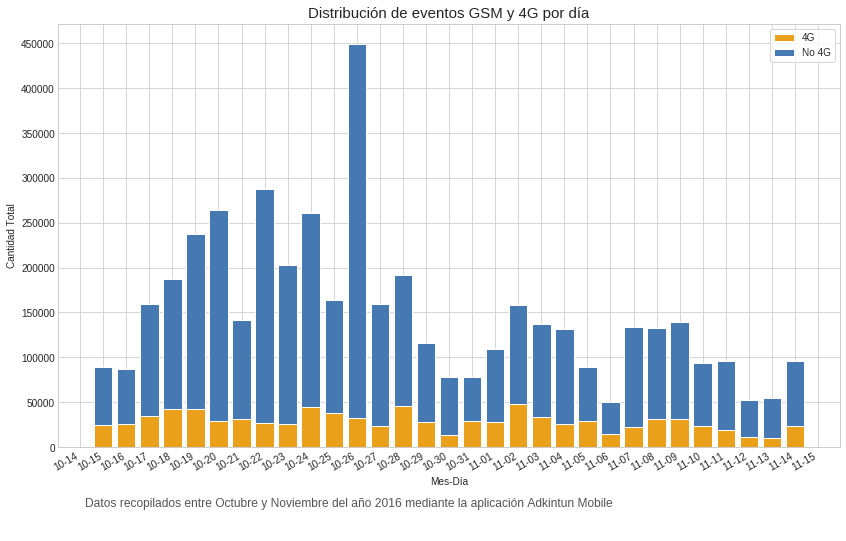

In [6]:
plotDateStackedBars(daygroup, ['4g_events', 'no4g_events'],['4G', 'No 4G'] ,['#EBA01B','#4678B2'],\
                   'Distribución de eventos GSM y 4G por día')

Del gráfico podemos ver que la mayor cantidad de mediciones se concentran en el mes de Octubre y que la proporción de eventos 4G es baja en relación con el total de la muestra.

También es posible distribuir los eventos GSM a lo largo de Santiago para hacerse una idea espacial del dataset con que estamos trabajando. A continuación se adjuntan dos mapas coropléticos, el primero con la distribución de los eventos a lo largo del Gran Santiago y el segundo con la distribución de los eventos 4G a lo largo de la ciudad:

In [7]:
#Leemos el GeoJSON de las comunas de Santiago con la libreria Geopandas, la cual interpreta los polígonos asociados
#al archivo leído.
comunas = gpd.read_file('comunas_santiago.json')
#Agrupamos por comuna, proyectamos network_type y contamos total de eventos (count) y eventos 4G (lambda)
eventos_comuna = stgo_events.groupby('comuna')['network_type'].agg(['count', (lambda x: (x==14).sum())]).reset_index()
eventos_comuna.columns = ['NOM_COM', 'total_events', '4g_events']
#Calculamos el total de eventos en escala logaritmica
eventos_comuna['log_total'] = np.log(eventos_comuna['total_events'])
#Calculamos los eventos 4G en escala logaritmica
eventos_comuna['log_4g'] = np.log(eventos_comuna['4g_events'])
#Hacemos un INNER JOIN entre el mapa de Santiago (comunas) y los valores calculados para cada comuna (eventos_comuna)
#esto genera una tabla que contiene el mapa de Santiago y columnas con información asociada al mapa
map_eventos = comunas.merge(eventos_comuna, on = 'NOM_COM', how = 'inner')

In [8]:
# pandasDataFrame, str, [str], [str], [tuple] -> None
# Plotea un mapa coroplético del Gran Santiago, dado un dataframe que contenga el mapa y la columna a plotear sobre éste.
# Además se pueden agregar un título y el color en que se hará el mapa coroplético, junto con el tamaño de la figura.
def plotChoropleth(df, col, title = 'Mapa Coroplético del Gran Santiago', color = 'Blues' , fsize = (20,12)):
    fig, ax = plt.subplots(1, figsize = fsize)
    df.plot(column = col, cmap = color, ax = ax, linewidth = 1.5, edgecolor = '0.4')
    #Taggeo de nombres de comuna en el mapa
    map_nombres = df.copy()
    map_nombres['centers'] = df['geometry'].centroid
    map_nombres.set_geometry('centers', inplace = True)
    texts = []
    for x, y, label in zip(map_nombres.geometry.x, map_nombres.geometry.y, map_nombres['NOM_COM']):
        texts.append(plt.text(x, y, label, fontsize = 10, color = '#1a1a1a'))
    aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), \
                   arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
    #Fin de taggeo de nombres
    valmin, valmax = df[col].min(), df[col].max()
    ax.axis('off')
    ax.set_title(title, fontdict = {'fontsize' : '20'})
    chbar = plt.cm.ScalarMappable(cmap = color, norm = plt.Normalize(vmin=valmin, vmax=valmax))
    chbar._A = []
    colorbar = fig.colorbar(chbar)



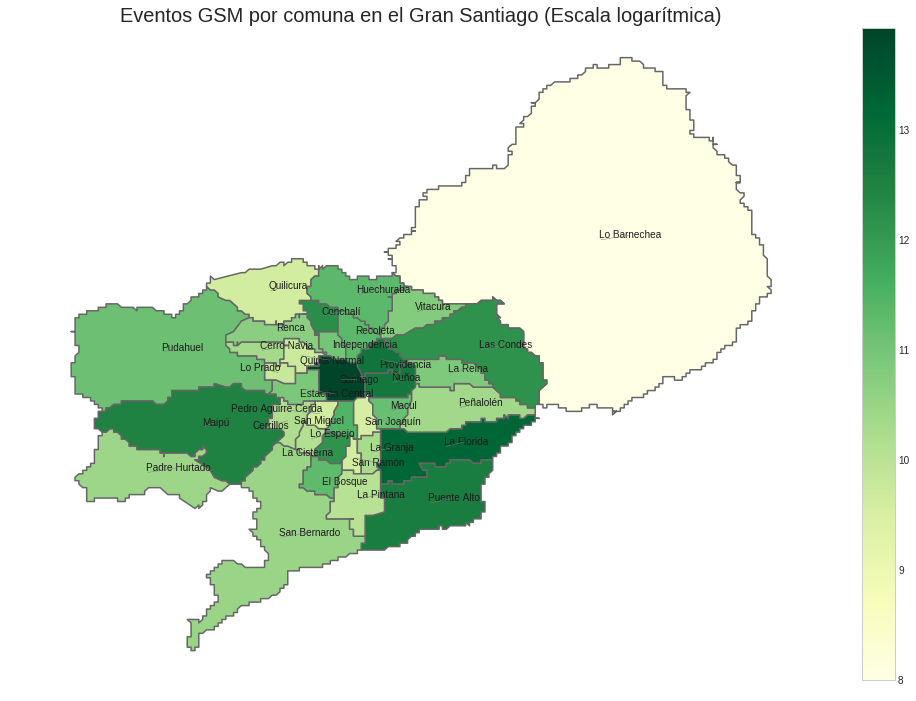

In [9]:
plotChoropleth(map_eventos, 'log_total', 'Eventos GSM por comuna en el Gran Santiago (Escala logarítmica)', 'YlGn')

Vemos que la mayor cantidad de eventos se registra en la comuna de Santiago y existen comunas comparables como La Florida o Maipú. Un dato interesante es la baja presencia de eventos GSM en la comuna de Lo Barnechea.

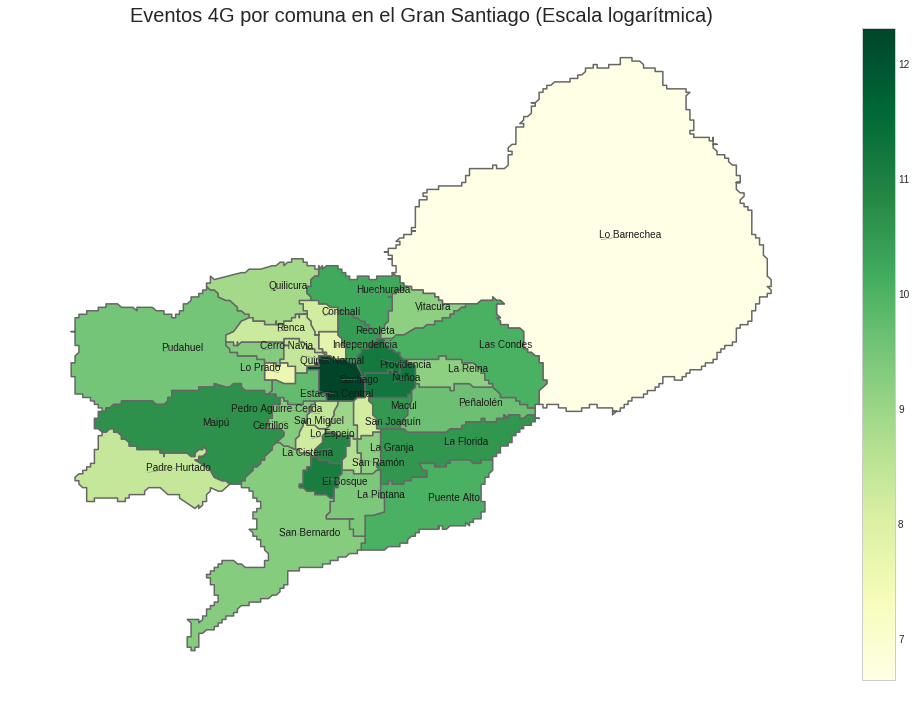

In [10]:
plotChoropleth(map_eventos, 'log_4g', 'Eventos 4G por comuna en el Gran Santiago (Escala logarítmica)', 'YlGn')

La distribución de eventos 4G comparte la concentración de eventos en la comuna de Santiago y se asemeja a la distribución general de eventos GSM, salvo por cambios en ciertas comunas que previamente presentaban una concentración mayor de eventos GSM, pero no lo hacen para el caso de eventos 4G, como por ejemplo Conchalí.

## Distribución de eventos por carrier

Como se dijo anteriormente, cada observación de "Eventos Santiago" contiene el carrier de la antena que registró el evento. Dentro de los carrier que se registran para el Gran Santiago se cuentan los siguientes:


* Entel
* WOM
* Movistar
* Claro

La siguiente gráfica muestra cómo se distribuye la totalidad de los eventos GSM entre los carriers versus el cómo se distribuyen los eventos exclusivamente 4G.

In [11]:
#Agrupamos los datos por carrier seleccionando solo la columna network_type y aplicamos dos funciones de agregación
#contar todos los elementos asociados al grupo y contar los eventos 4G asociados al grupo (la lambda hace lo ultimo)
carriergroup = stgo_events.groupby('carrier_name')['network_type'].agg(['count', (lambda x: (x == 14).sum())]).reset_index()
carriergroup.columns = ['carrier_name', 'total_events', '4g_events']

In [12]:
#Determinamos la porcentualidad de los eventos calculando el total por grupo sobre el total de la tabla para GSM y 4G
carriergroup['total_percent'] = carriergroup['total_events']/carriergroup['total_events'].sum()
carriergroup['4g_percent'] = carriergroup['4g_events']/carriergroup['4g_events'].sum()

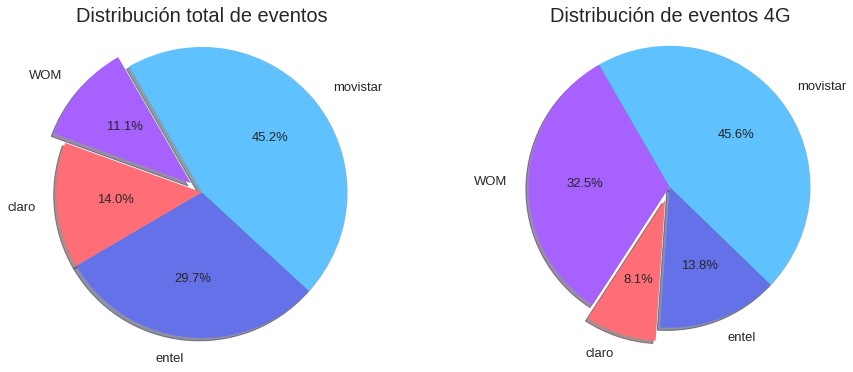

In [13]:
#Ploteo de los datos antes calculados
fig3, (ax3a, ax3b) = plt.subplots(1, 2, sharey=False, figsize = (14,6))
plt.subplots_adjust(wspace = 0.5) #Ajuste de distancia entre subplots
carriercolors = ['#A661FF', '#FF6E77', '#6471E8', '#5FC2FF']

explode3a = (0.1, 0, 0, 0)
explode3b = (0, 0.1, 0, 0)
ax3a.pie(carriergroup['total_percent'], explode = explode3a, labels=carriergroup['carrier_name'],\
        colors = carriercolors, autopct='%1.1f%%', shadow=True, startangle=120, labeldistance = 1.15, \
        textprops = {'fontsize' : '13'})

ax3a.set_title('Distribución total de eventos', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax3a.axis('equal')
ax3b.pie(carriergroup['4g_percent'], explode = explode3b, labels = carriergroup['carrier_name'], \
        colors = carriercolors, autopct = '%1.1f%%', shadow = True, startangle = 120, labeldistance = 1.15, \
        textprops = {'fontsize' : '13'})
ax3b.set_title('Distribución de eventos 4G', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax3b.axis('equal')
plt.show()

Vemos que, con excepción de Movistar, existe una diferencia entre la proporción total de servicios prestados y la proporción de servicios 4G prestados. No hay que olvidar que estas proporciones se hallan dentro del dataset trabajado.

Con estas proporciones presentes, se adjunta la distribución de los eventos GSM por día considerando el carrier asociado a cada evento:

In [14]:
#Agrupamos por día y carrier y contamos la cantidad total de eventos
daycarriergroup = stgo_events.groupby([pd.Grouper(key = 'date', freq = 'D'), 'carrier_name'])['event_id'].\
                    count().reset_index()
daycarriergroup.rename(columns = {'event_id' : 'total_events'}, inplace = True)
#Dado que la tabla anterior tiene una estructura agrupada, hay que desagrupar los valores para plotearlos
carrierlabels = ['WOM', 'claro', 'entel', 'movistar']
#Extraemos los valores de las columnas de cada carrier. Cumplen con estar ordenados por fecha
carriercols = [daycarriergroup.loc[(daycarriergroup['carrier_name'] == x)]['total_events'].reset_index(drop = True) for x in carrierlabels]
#Lista que Series que contiene las fechas y los la cantidad de eventos para cada carrier
series = [pd.Series(daycarriergroup['date'].unique())]+carriercols
#Generamos el dataframe con las fechas y los eventos de cada carrier
dfdaycarrier = pd.concat(series, axis = 1, ignore_index = True)
dfdaycarrier.columns = ['date'] + carrierlabels

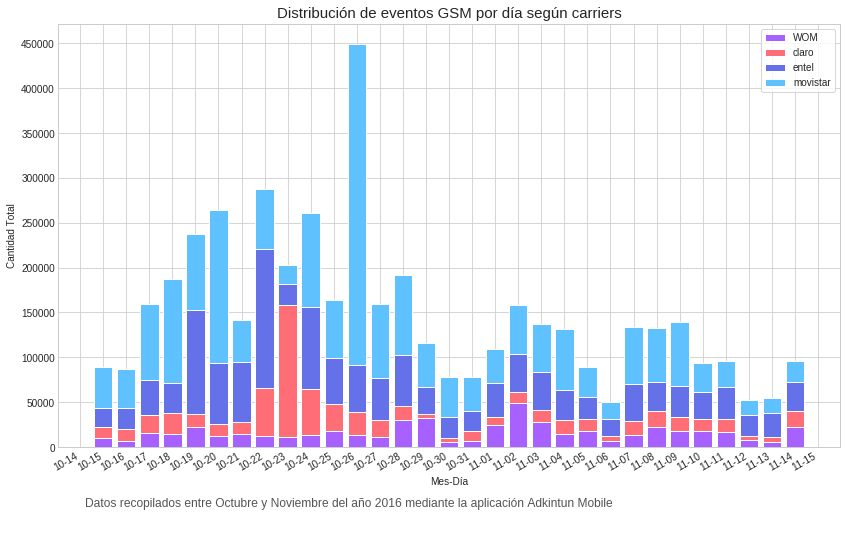

In [15]:
plotDateStackedBars(dfdaycarrier, carrierlabels, carrierlabels, carriercolors, 'Distribución de eventos GSM por día según carriers')

## Distribución de eventos por identificador SIM

Cada evento dentro del dataset tiene un identificador SIM asociado, el cual permite contextualizar los datos y saber qué  eventos están ligados entre sí y cómo se suceden en el tiempo. A continuación se presentan dos histogramas para ver cómo distribuyen la cantidad total de eventos y los eventos 4G que registra cada identificador SIM en "Eventos Santiago":

In [16]:
#Agrupamos los eventos por SIM y contamos tanto los eventos totales como los 4G asociados.
simgroup = stgo_events.groupby('sim_serial_number')['network_type'].agg(['count', (lambda x: (x == 14).sum())]).reset_index()
simgroup.columns = ['sim_serial_number', 'total_events', '4g_events']

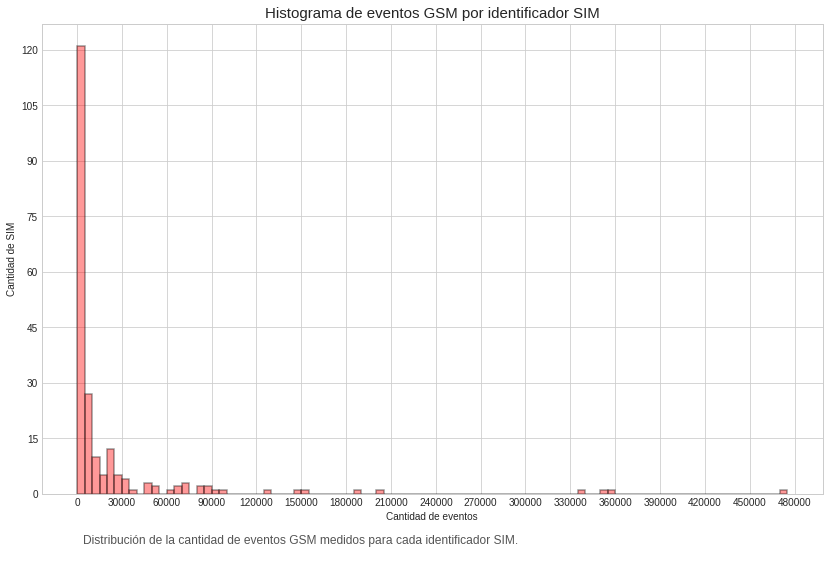

In [17]:
fig4a, ax4a = plt.subplots(figsize=(14,8.65))
sns.distplot(simgroup['total_events'],\
             hist=True, kde=False, bins='auto', color = 'red', ax = ax4a, hist_kws=dict(edgecolor="k", linewidth=1.5))
ax4a.set(xlabel='Cantidad de eventos', ylabel='Cantidad de SIM')
ax4a.set_title('Histograma de eventos GSM por identificador SIM', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4a.annotate('Distribución de la cantidad de eventos GSM medidos para cada identificador SIM.', xy=(0.1, .048),\
                xycoords= 'figure fraction',\
                horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
ax4a.yaxis.set_major_locator(plt.MaxNLocator(10))
ax4a.xaxis.set_major_locator(plt.MaxNLocator(20))

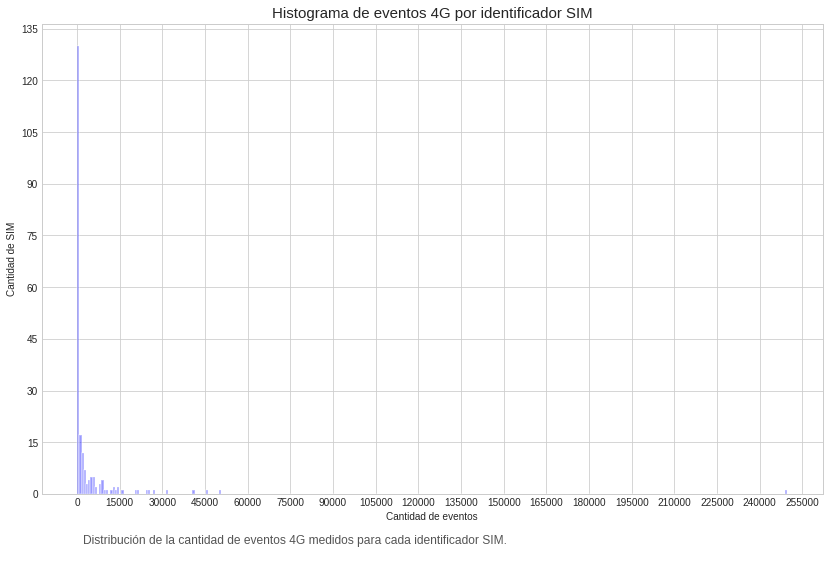

In [18]:
fig5a, ax5a = plt.subplots(figsize=(14,8.65))
sns.distplot(simgroup['4g_events'], \
             hist=True, kde=False, bins='auto', color = 'blue', ax = ax5a, hist_kws=dict(edgecolor="w", linewidth=1.5))
ax5a.set(xlabel='Cantidad de eventos', ylabel='Cantidad de SIM')
ax5a.set_title('Histograma de eventos 4G por identificador SIM', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax5a.annotate('Distribución de la cantidad de eventos 4G medidos para cada identificador SIM.', xy=(0.1, .048),\
                xycoords= 'figure fraction',\
                horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
ax5a.yaxis.set_major_locator(plt.MaxNLocator(10))
ax5a.xaxis.set_major_locator(plt.MaxNLocator(20))

Ambas gráficas permiten observar outliers dentro de la muestra, pero no facilitan la comprensión real de la cantidad de eventos registrados. Por esto, se adjuntan las gráficas ajustadas hasta el percentil 75 de cada muestra.

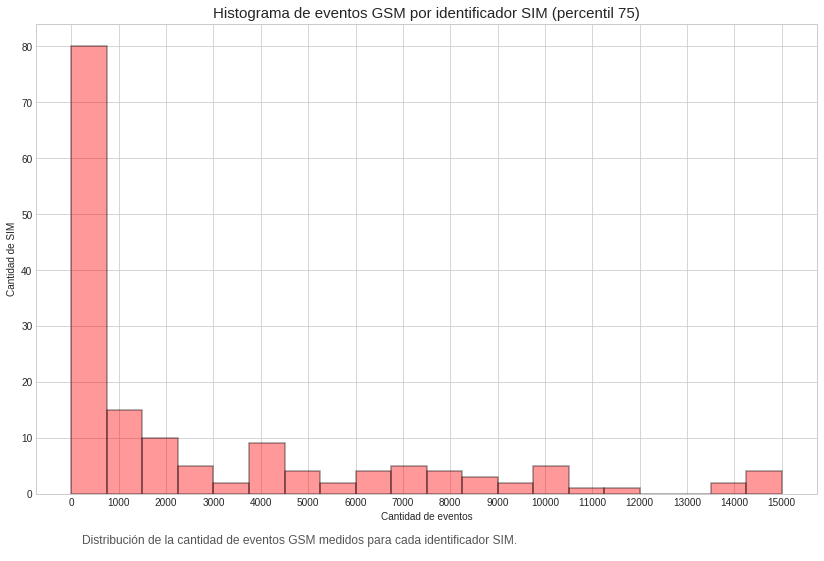

In [19]:
fig4b, ax4b = plt.subplots(figsize=(14,8.65))
sns.distplot(simgroup[simgroup['total_events'] < simgroup['total_events'].quantile(0.75)]['total_events'],\
             hist=True, kde=False, bins=20, color = 'red', ax = ax4b, hist_kws=dict(edgecolor="k", linewidth=1.5))
ax4b.set(xlabel='Cantidad de eventos', ylabel='Cantidad de SIM')
ax4b.set_title('Histograma de eventos GSM por identificador SIM (percentil 75)',\
               fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4b.annotate('Distribución de la cantidad de eventos GSM medidos para cada identificador SIM.', xy=(0.1, .048),\
                xycoords= 'figure fraction',\
                horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
ax4b.yaxis.set_major_locator(plt.MaxNLocator(10))
ax4b.xaxis.set_major_locator(plt.MaxNLocator(20))

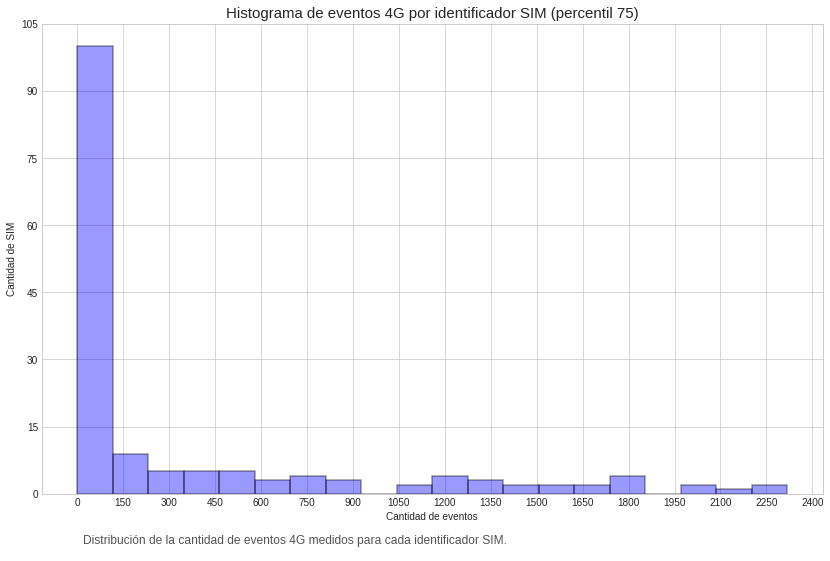

In [20]:
fig5b, ax5b = plt.subplots(figsize=(14,8.65))
sns.distplot(simgroup[simgroup['4g_events'] < simgroup['4g_events'].quantile(0.75)]['4g_events'], \
             hist=True, kde=False, bins=20, color = 'blue', ax = ax5b, hist_kws=dict(edgecolor='k', linewidth=1.5))
ax5b.set(xlabel='Cantidad de eventos', ylabel='Cantidad de SIM')
ax5b.set_title('Histograma de eventos 4G por identificador SIM (percentil 75)',\
               fontdict={'fontsize': '15', 'fontweight' : '3'})
ax5b.annotate('Distribución de la cantidad de eventos 4G medidos para cada identificador SIM.', xy=(0.1, .048),\
                xycoords= 'figure fraction',\
                horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
ax5b.yaxis.set_major_locator(plt.MaxNLocator(10))
ax5b.xaxis.set_major_locator(plt.MaxNLocator(20))

De ambas gráficas se puede apreciar que ni la cantidad de eventos GSM ni 4G tienen una distribución homogénea sobre los distintos identificadores SIM registrados y que en el caso 4G existen aproximadamente 100 identificadores SIM que registran entre 0 y 150 eventos 4G. Con esto en mente, es pertinente determinar cuál es la cantidad total de identificadores SIM que presenta el dataset y qué cantidad de éstos presenta realmente eventos 4G en sus registros.

La siguiente gráfica muestra cuántos identificadores SIM existen en la muestra y la proporción de aquellos que presentan 4G en sus registros contra los que no.

In [21]:
#Agrupamos los eventos de Santiago por SIM y filtramos aquellos que no presenten ningún evento del tipo LTE (14),
#lo cual se ve en la condición (x['network_type'] == 14).sum() != 0
#Esta tabla se usará en la siguiente sección para hacer el análisis 4G
stgo_events_4g = stgo_events.groupby('sim_serial_number', sort = 'false').\
                    filter(lambda x: (x['network_type'] == 14).sum() != 0).reset_index(drop = True)
#Determinamos la cantidad de SIMs presentes en la tabla recien creada
nonly4g = len(stgo_events_4g.groupby('sim_serial_number').groups)
#Determinamos la cantidad de SIMs presentes en la tabla Eventos Santiago
ngsm = len(stgo_events.groupby('sim_serial_number').groups)

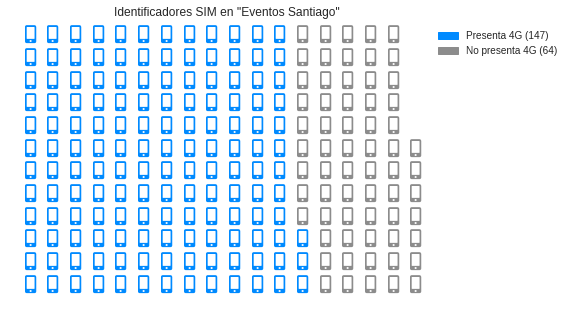

In [22]:
#Ploteo del tipo "waffle chart"
fig6 = plt.figure(figsize = (8, 20),
    FigureClass=Waffle, 
    rows=12,
    values=(nonly4g, ngsm-nonly4g),
    colors = ('#008AFF', '#8C8C8C'),    
    title={'label': 'Identificadores SIM en \"Eventos Santiago\"', 'loc': 'center'},
    labels=["Presenta 4G"+' ({})'.format(nonly4g), "No presenta 4G"+' ({})'.format(ngsm-nonly4g)],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.0, 1),},
    icons = 'mobile-alt', icon_size = '18'
)

Con esta información se hace pertinente filtrar aquellas observaciones que no estén ligadas a un identificador SIM que contenga eventos 4G asociados, ya que de otra manera los datos presentarán un sesgo hacia los eventos No4G que afectará las conclusiones de las mediciones futuras.

# Análisis 4G: filtrando el dataset

Como se dijo anteriormente, para hacer el análisis sobre eventos 4G será necesario eliminar aquellas observaciones que no estén ligadas a un identificador SIM que contenga eventos 4G en sus registros. Además, será necesario filtrar aquellas comunas que no contengan una cantidad suficiente de datos como para hacer un análisis representativo del lugar, ya que el fin del análisis es estudiar el comportamiento de los eventos 4G por comunas. Con esta idea, a continuación se muestra un gráfico de barras con la cantidad de eventos GSM registrados por comuna: 

In [23]:
#Por una cuestion de orden, generamos una copia de los eventos Santiago para SIMs que registren 4G
stgo_4g = stgo_events_4g.copy()
#Ahora, contamos la cantidad de registros por comuna.
comuna_count = stgo_4g.groupby('comuna')['event_id'].count().reset_index().sort_values(by = 'event_id')

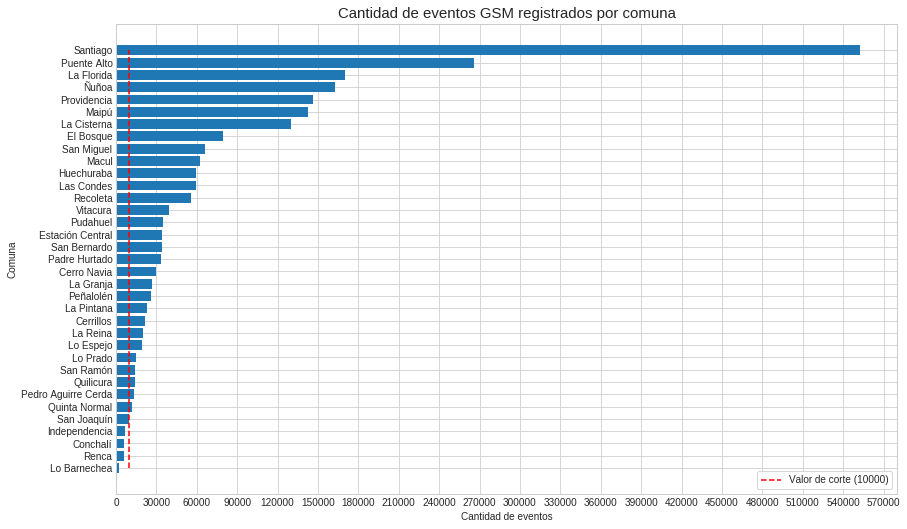

In [24]:
figcom, axcom = plt.subplots(figsize = (14, 8.65))
diezmil = [10000]*len(comuna_count['comuna'])
axcom.barh(comuna_count['comuna'],comuna_count['event_id'])
axcom.plot(diezmil, comuna_count['comuna'], linestyle = '--', color = 'red', label = 'Valor de corte (10000)')
axcom.set(xlabel = 'Cantidad de eventos', ylabel = 'Comuna',)
axcom.set_title('Cantidad de eventos GSM registrados por comuna', fontdict = {'fontsize': '15', 'fontweight' : '3'})
axcom.legend(loc = 4, frameon = True)
axcom.xaxis.set_major_locator(plt.MaxNLocator(20))

En el gráfico, la línea punteada representa el valor de corte que se considerará para la representatividad de los datos. Este  valor es de 10000 observaciones. Toda comuna que contenga una menor cantidad de observaciones no será considerada para el análisis futuro.

In [25]:
#Filtramos el dataset a partir del criterio establecido anteriormente (10000 observaciones o más)
stgo_4g = stgo_4g.groupby('comuna', sort = 'false').filter(lambda x : len(x) >= 10000)

Con todo esto, el dataset final registra aproximadamente 2.3 millones de eventos repartidos entre 147 identificadores SIM. Para hacer una idea general del dataset, se muestra la distribución por día de los eventos GSM y 4G:

In [26]:
#Agrupamos los datos por día, proyectando la columna network_type y ejecutamos dos agregaciones
#una cuenta total de observaciones (count) y una cuenta de aquellas que sean 4G (lambda)
day4g = stgo_4g.groupby([pd.Grouper(key = 'date', freq = 'D')])['network_type'].\
            agg(['count', (lambda x: (x == 14).sum())]).reset_index()
day4g.columns = ['date','total_events','4g_events']
day4g['no4g_events'] = day4g['total_events'] - day4g['4g_events']

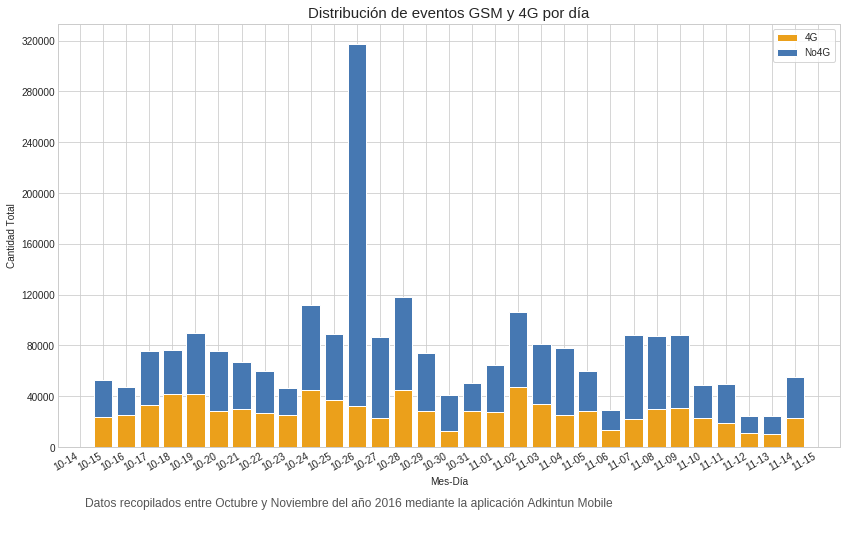

In [27]:
plotDateStackedBars(day4g, ['4g_events','no4g_events'], ['4G', 'No4G'], ['#EBA01B','#4678B2'],\
                    'Distribución de eventos GSM y 4G por día')

Se puede apreciar un cambio significativo en la proporción que ocupan los eventos 4G, comparando con la primera figura mostrada al inicio de la sección *Descripción general del dataset*. Un detalle interesante es que el día 26 de Octubre sigue registrando el máximo valor dentro de los datos, al igual que en el caso de los datos sin filtrar.

## ¿Como queda la distribución de carriers?

Dado que filtramos una cantidad grande de eventos GSM, es necesario volver a ejecutar el análisis de proporción de eventos GSM y 4G sobre los carriers. La siguiente gráfica muestra como queda esta proporción sobre el nuevo dataset.

In [28]:
#Agrupamos los datos por carrier seleccionando solo la columna network_type y aplicamos dos funciones de agregación
#contar todos los elementos asociados al grupo y contar los eventos 4G asociados al grupo (la lambda hace lo ultimo)
carrier4g = stgo_4g.groupby('carrier_name')['network_type'].agg(['count', (lambda x: (x == 14).sum())]).reset_index()
carrier4g.columns = ['carrier_name', 'total_events', '4g_events']

In [29]:
#Determinamos la porcentualidad de los eventos calculando el total por grupo sobre el total de la tabla para GSM y 4G
carrier4g['total_percent'] = carrier4g['total_events']/carrier4g['total_events'].sum()
carrier4g['4g_percent'] = carrier4g['4g_events']/carrier4g['4g_events'].sum()

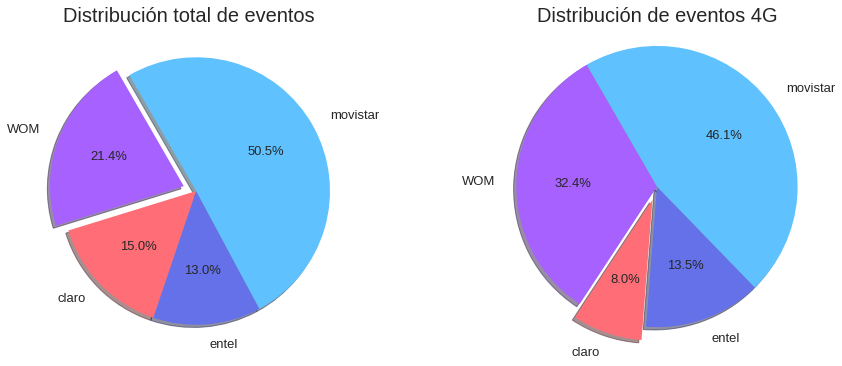

In [30]:
#Ploteo de los datos antes calculados
fig7, (ax7a, ax7b) = plt.subplots(1, 2, sharey=False, figsize = (14,6))
plt.subplots_adjust(wspace = 0.5) #Ajuste de distancia entre subplots
carriercolors = ['#A661FF', '#FF6E77', '#6471E8', '#5FC2FF']

explode7a = (0.1, 0, 0, 0)
explode7b = (0, 0.1, 0, 0)
ax7a.pie(carrier4g['total_percent'], explode = explode7a, labels=carrier4g['carrier_name'],\
        colors = carriercolors, autopct='%1.1f%%', shadow=True, startangle=120, labeldistance = 1.15, \
        textprops = {'fontsize' : '13'})

ax7a.set_title('Distribución total de eventos', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax7a.axis('equal')
ax7b.pie(carrier4g['4g_percent'], explode = explode7b, labels = carrier4g['carrier_name'], \
        colors = carriercolors, autopct = '%1.1f%%', shadow = True, startangle = 120, labeldistance = 1.15, \
        textprops = {'fontsize' : '13'})
ax7b.set_title('Distribución de eventos 4G', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax7b.axis('equal')
plt.show()

Existe un cambio significativo con respecto a los eventos asociados a Entel en la distribución total de eventos, dándole más espacio a WOM y Claro. Por su parte, la distribución de eventos 4G sigue igual, dado que los datos de esta gráfica no cambiaron (los eventos 4G de antes son los mismos que los de ahora). Para detallar más la distribución 4G, se adjunta la gráfica de la distribución de eventos 4G por día considerando el carrier.

In [31]:
#Agrupamos por día y carrier y contamos la cantidad total de eventos 4G
daycarrier4g = stgo_4g.groupby([pd.Grouper(key = 'date', freq = 'D'), 'carrier_name'])['network_type'].\
                    agg((lambda x : (x == 14).sum())).reset_index()
daycarrier4g.columns = ['date', 'carrier_name', 'total_4g']
#Dado que la tabla anterior tiene una estructura agrupada, hay que desagrupar los valores para plotearlos
carrierlabels = ['WOM', 'claro', 'entel', 'movistar']
#Extraemos los valores de las columnas de cada carrier. Cumplen con estar ordenados por fecha
carriercols = [daycarrier4g.loc[(daycarrier4g['carrier_name'] == x)]['total_4g'].reset_index(drop = True) for x in carrierlabels]
#Lista que Series que contiene las fechas y los la cantidad de eventos para cada carrier
series = [pd.Series(daycarrier4g['date'].unique())]+carriercols
#Generamos el dataframe con las fechas y los eventos de cada carrier
dfdaycarrier4g = pd.concat(series, axis = 1, ignore_index = True)
dfdaycarrier4g.columns = ['date'] + carrierlabels

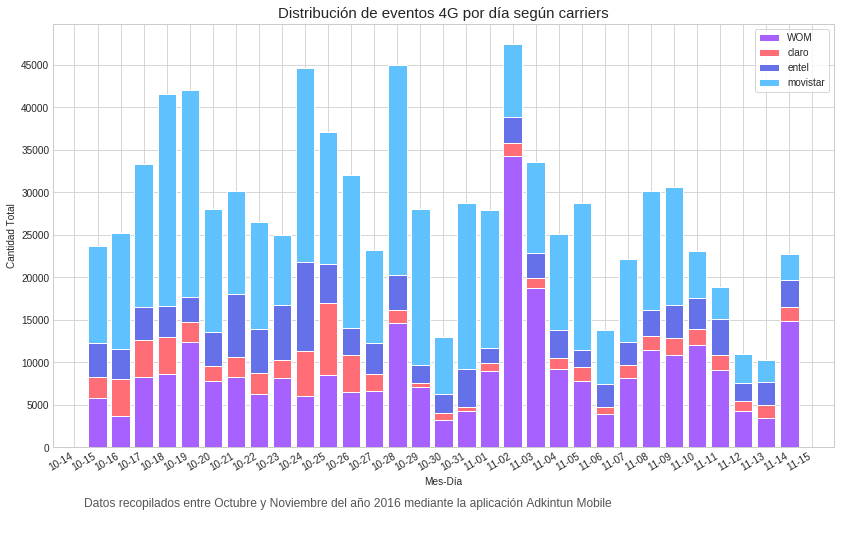

In [32]:
plotDateStackedBars(dfdaycarrier4g, carrierlabels, carrierlabels, carriercolors, 'Distribución de eventos 4G por día según carriers')

## ¿Y la distribución geográfica?

Dado que anteriormente se mostraron los eventos GSM y 4G en Santiago con el dataset completo, se adjuntan los mapas con el dataset filtrado para ver el cambio en la muestra:

In [33]:
#Agrupamos por comuna, proyectamos network_type y contamos total de eventos (count) y eventos 4G (lambda)
comunas_4g = stgo_4g.groupby('comuna')['network_type'].agg(['count', (lambda x : (x==14).sum())]).reset_index()
comunas_4g.columns = ['NOM_COM', 'total_events', '4g_events']
#Transformamos a escala logaritmica los eventos totales
comunas_4g['log_total'] = np.log(comunas_4g['total_events'])
#Transformamos a escala logarítmica los eventos 4g
comunas_4g['log_4g'] = np.log(comunas_4g['4g_events'])
#Hacemos un INNER JOIN entre el mapa de Santiago (comunas) y los valores calculados para cada comuna (eventos_comuna)
#esto genera una tabla que contiene el mapa de Santiago y columnas con información asociada al mapa1
map_eventos_4g = comunas.merge(comunas_4g, on = 'NOM_COM', how = 'inner')

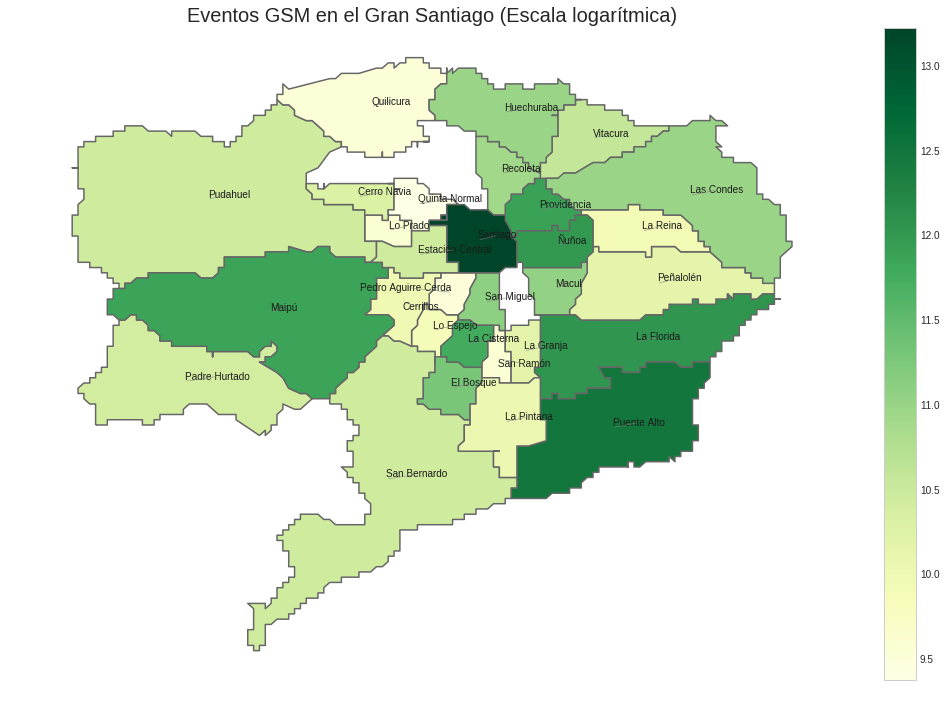

In [34]:
plotChoropleth(map_eventos_4g, 'log_total', color = 'YlGn', title = 'Eventos GSM en el Gran Santiago (Escala logarítmica)')

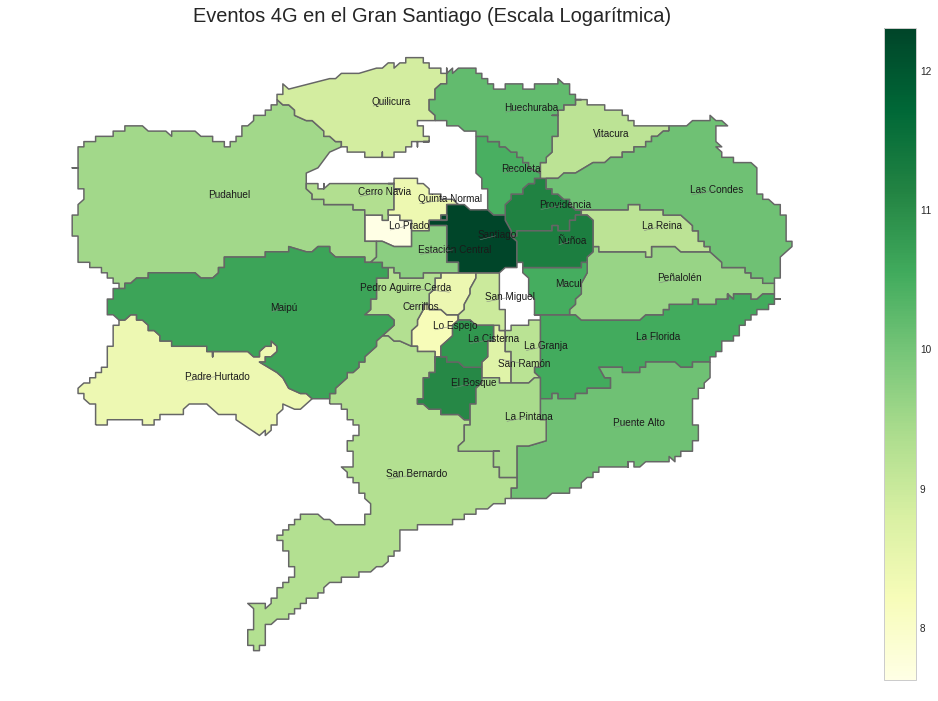

In [35]:
plotChoropleth(map_eventos_4g, 'log_4g', color = 'YlGn', title = 'Eventos 4G en el Gran Santiago (Escala Logarítmica)')

La distribución de eventos 4G no se modifica salvo por aquellas comunas que ya no aparecen en el mapa y se mencionaron previamente. Notar que Lo Prado es una de las comunas que registra la menor cantidad de eventos 4G al igual que GSM.

Con todo esto, ya están las condiciones para ejecutar un análisis sobre los servicios 4G presentes en el dataset "Santiago 4G".

## Analizando desconexiones 4G.

En la siguiente sección se contarán la cantidad de desconexiones de servicio 4G que se registran dentro de los eventos en "Santiago 4G". Para explicitar qué se entiende por desconexión se dirá que: 


- Dada una secuencia de eventos ordenados por fecha $E = \{ e_0, e_1, e_2,\ ...\ , e_N\}$,  existe una desconexión 4G si dado un evento $e_{k}\in E$ que es 4G, el evento siguiente $e_{k+1}\in E$ no es 4G y la diferencia de tiempo entre ambos eventos no es superior a una hora. Denotaremos al evento $e_{k}$ como el ***evento out*** o de salida y al evento $e_{k+1}$ como el ***evento in*** o de llegada.
 
El análisis se hace sobre las observaciones asociadas a los 147 identificadores SIM de la muestra, analizando sus eventos individual y secuencialmente para encontrar posibles desconexiones. Cada desconexión guarda los siguientes atributos:


* **event_id** : Id del evento asociado a la desconexión.
* **sim_serial_number** : Identificador SIM asociado al evento de desconexión.
* **date_out** : Timestamp asociado al evento previo a la desconexión.
* **date_in** : Timestamp asociado al evento de desconexión.
* **antenna_out** : Antena asociado al evento previo a la desconexión.
* **antenna_in** : Antena asociada al evento de desconexión.
* **carrier_out** : Carrier de la antena previa a la desconexión.
* **carrier_in** : Carrier de la antena asociada al evento de desconexión.
* **place_out** : Comuna del evento previo a la desconexión (de dónde viene el identificador SIM).
* **place_in** : Comuna donde se genera la desconexión (a dónde llegó el identificador SIM cuando se desconectó).
* **net_type_out** : Network type antes de la desconexión (para el caso todos han de ser LTE)
* **net_type_in** : Network type del evento de la desconexión.

Además, consideraremos una desconexión válida si el valor de *net_type_in* corresponde a una tecnología 3G o 2G. En caso contrario, la desconexión no será contabilizada.

In [36]:
#Agrupamos los eventos por SIM de 'Santiago 4G'
sim_grouped = stgo_4g.groupby('sim_serial_number', sort='false')

In [37]:
#Iteramos para extraer las desconexiones de la tabla de sims agrupada.
#Recordemos el header de los eventos gsm:
#'event_id','antenna_id', 'network_type', 'date', 'sim_serial_number',
#'cid', 'lac','lat','lon','carrier_id','comuna','carrier_name','mcc','mnc'
disconnections = []
disc_columns = ['event_id', 'sim_serial_number', 
                'date_out', 'date_in',
                'antenna_out', 'antenna_in',
               'carrier_out', 'carrier_in',
               'place_out', 'place_in',
               'net_type_in', 'net_type_out']
for sim, group in sim_grouped:
    tope = len(group.index)
    #Se itera sobre todas las filas del dataframe asociado a la sim
    for i in range(tope):
        inext = i+1
        #Si inext es igual a "tope", se acaba la iteración
        if inext == tope: break
        this_nettype = group.iat[i, 2] #Extraemos networktype
        if this_nettype == 14: #Es 4G el evento?
            #De ser así, miro el evento inmediato
            next_nettype = group.iat[inext, 2]
            if this_nettype != next_nettype: #Son distintos, hay desconexion
                info = (group.iat[inext, 0], group.iat[inext, 4],
                        group.iat[i, 3], group.iat[inext, 3],
                        group.iat[i, 1], group.iat[inext, 1],
                        group.iat[i, 11], group.iat[inext, 11],
                        group.iat[i, 10], group.iat[inext, 10],
                        dict_tecs[group.iat[i,2]], dict_tecs[group.iat[inext,2]])
                disconnections.append(info)
            else:
                continue
        else: #El evento no es 4G, no busco desconexion
            continue

### Proceso de filtrado: chequeo de diferencias de tiempo y tipo de evento de llegada.

Sin aplicar el filtro de tiempo entre eventos de desconexión *out* e *in* (una hora máximo de diferencia) se tiene que:

In [38]:
#Generamos un dataframe para manejar las desconexiones
disconnect_df = pd.DataFrame(disconnections, columns = disc_columns)
#Calcuamos las diferencias de tiempo entre evento 4G y No4G de las desconexiones y las agregamos la dataframe
disconnect_df['deltatime'] = disconnect_df['date_in']-disconnect_df['date_out']
print(f"Tamaño del dataset de desconexiones: {disconnect_df.shape[0]}")

Tamaño del dataset de desconexiones: 41789


Cuando se aplica el filtro de tiempo, la cantidad de desconexiones es la siguiente:

In [39]:
#Filtramos aquellas desconexiones que tengan una diferencia de tiempo más grande que una hora
disconnect_df = disconnect_df[disconnect_df['deltatime'] < pd.Timedelta('1 hour')]
print(f"Tamaño del dataset de desconexiones: {disconnect_df.shape[0]}")

Tamaño del dataset de desconexiones: 41516


No generándose una diferencia significativa de cardinalidad. Ahora, revisando los tipos de red registrados en los eventos de llegada se cuentan los siguientes:

In [40]:
#Miramos qué tipo de red registran los eventos de desconexión
nettypecount = disconnect_df['net_type_out'].value_counts()
nettable = nettypecount.reset_index()
nettable.columns = ['Tipo de Red', 'Cantidad']
print(nettable)

  Tipo de Red  Cantidad
0        UMTS     17345
1     UNKNOWN     15493
2        HSPA      5054
3       HSPAP      2208
4       HSUPA       815
5       OTHER       230
6       HSDPA       226
7        EDGE       120
8        GPRS        25


Los tipos *UMTS, HSPA, HSPAP, HSUPA* y *HSDPA* corresponden a protocolos o sistemas 3G, mientras que *EDGE* y *GPRS* corresponden a tecnologías 2G. Por lo tanto, los eventos que contienen la etiqueta *UNKNOWN* y *OTHER* deberán ser filtrados, pues no se puede determinar si realmente se registró una desconexión 4G.

Con este último filtro se tiene que:

In [41]:
#Vemos que los network_type inválidos son UNKNOWN y OTHER, pues no tenemos información de estos eventos
#por lo tanto, los filtramos.
#Para verificar que el filtrado esté  correcto, guardamos el largo del dataset previo al filtrado
ndisconprefilter = disconnect_df.shape[0]
#La cantidad de UNKNOWN
nunknown = nettypecount['UNKNOWN']
#La cantidad de OTHER
nother = nettypecount['OTHER']

In [42]:
#Filtramos UNKNOWN y OTHER
disconnect_final  = disconnect_df.loc[(disconnect_df['net_type_out'] != 'UNKNOWN') & (disconnect_df['net_type_out'] != 'OTHER')]
#Verificamos que las cardinalidades calcen después del filtrado
assert(ndisconprefilter== disconnect_final.shape[0]+nunknown+nother)
print(f'Se registran {disconnect_final.shape[0]} desconexiones 4G')

Se registran 25793 desconexiones 4G


### Verificación de desconexiones: diferencia de tiempo entre eventos *out* e *in*

Finalmente, para verificar que las desconexiones extraídas son realmente desconexiones y no eventos independientes, se hace un análisis sobre la diferencia de tiempo entre los eventos de salida y llegada. El siguiente histograma muestra la distribución de las diferencias de tiempo entre los eventos de desconexión:

In [43]:
#Extraemos los delta de tiempo para ver cómo se distribuyen
deltas = disconnect_final['deltatime'].astype('timedelta64[s]').sort_values()

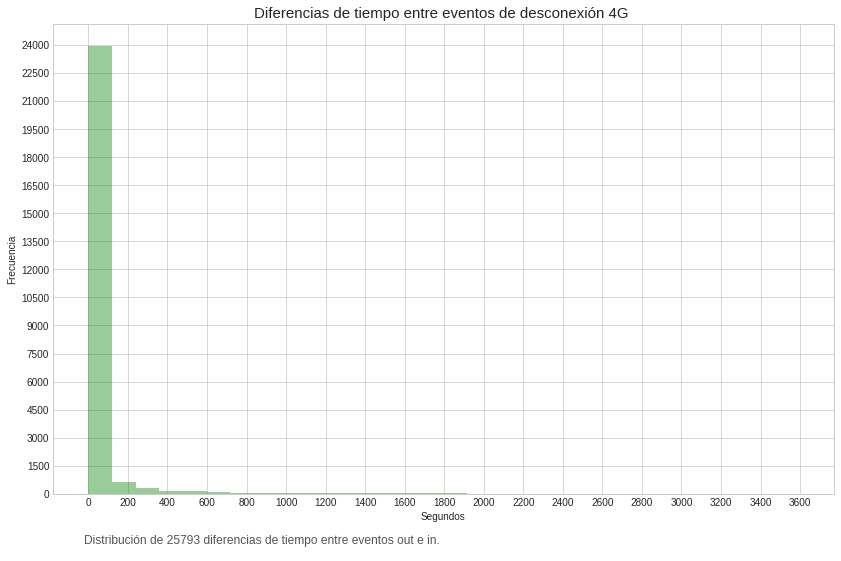

In [44]:
fig8, ax8 = plt.subplots(figsize=(14,8.65))
sns.distplot(deltas, hist=True, kde=False, bins=30, color = 'green', ax = ax8)
ax8.set_title('Diferencias de tiempo entre eventos de desconexión 4G ', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax8.set(xlabel='Segundos', ylabel='Frecuencia')
ax8.yaxis.set_major_locator(plt.MaxNLocator(20))
ax8.xaxis.set_major_locator(plt.MaxNLocator(20))
ax8.annotate('Distribución de 25793 diferencias de tiempo entre eventos out e in.', xy=(0.1, .048),  xycoords= 'figure fraction',\
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

El anterior gráfico no es claro determinando la frecuencia de la mayor parte de la muestra, por lo que generaremos un histograma con los datos presentes hasta el percentil 90.

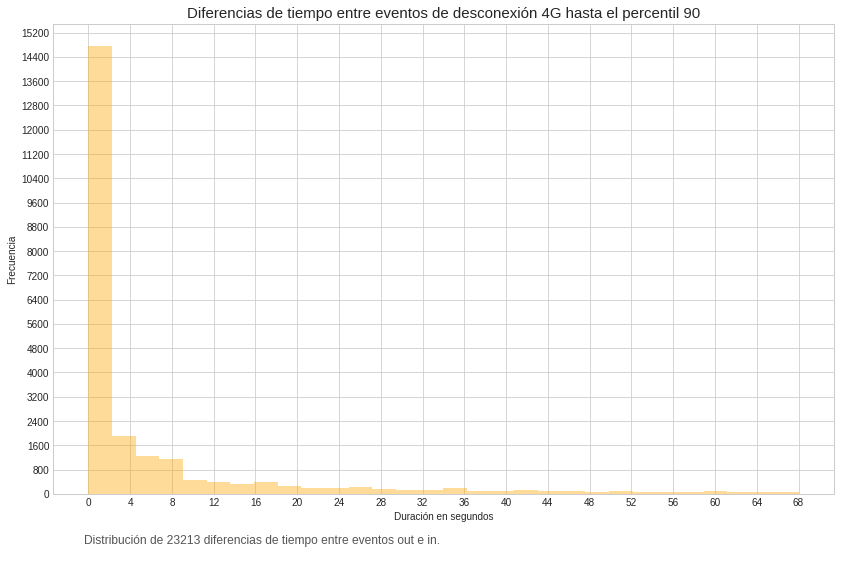

In [45]:
fig9, ax9 = plt.subplots(figsize=(14,8.65))
#En distplot, el primer argumento contiene los datos recortados hasta el percentil 90
sns.distplot(deltas[deltas < deltas.quantile(0.9)], hist=True, kde=False, bins=30, color = 'orange', ax = ax9)
ax9.set_title('Diferencias de tiempo entre eventos de desconexión 4G hasta el percentil 90', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax9.set(xlabel='Duración en segundos', ylabel='Frecuencia')
ax9.yaxis.set_major_locator(plt.MaxNLocator(20))
ax9.xaxis.set_major_locator(plt.MaxNLocator(20))
ax9.annotate('Distribución de 23213 diferencias de tiempo entre eventos out e in.', xy=(0.1, .048),  xycoords= 'figure fraction',\
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

Con este último gráfico se puede ver que el tiempo transcurrido entre los eventos de desconexión (*out* e *in*) no supera los 68 segundos para el 90% de la muestra, con lo que se verifica que las desconexiones encontradas se dan entre eventos relativamente inmediatos.

### ¿Dónde ocurren las desconexiones?

Ya teniendo los datos de las desconexiones, se ubicarán las comunas donde éstas se registran y su cantidad respectiva. Se entenderá el lugar de la desconexión como el lugar de llegada donde se genera la desconexión (*place_in* en la especificación de atributos de las desconexiones). A continuación se presenta un mapa del Gran Santiago que ubica la cantidad de desconexiones por comuna: 

In [46]:
#Generamos un tabla que cuente las desconexiones para cada comuna de llegada
discon_comuna = (disconnect_final.groupby('place_in')['event_id'].agg('count').reset_index()). \
    rename(columns = {'place_in': 'NOM_COM', 'event_id' : 'total_discon'})
#Calculamos el total de desconexiones en escala logaritmica
discon_comuna['log_total_discon'] = np.log(discon_comuna['total_discon'])
#Hacemos un INNER JOIN entre el mapa de comunas de Santiago y la cantidad de desconexiones medida anteriormente
map_discon = comunas.merge(discon_comuna, on = 'NOM_COM', how = 'inner')

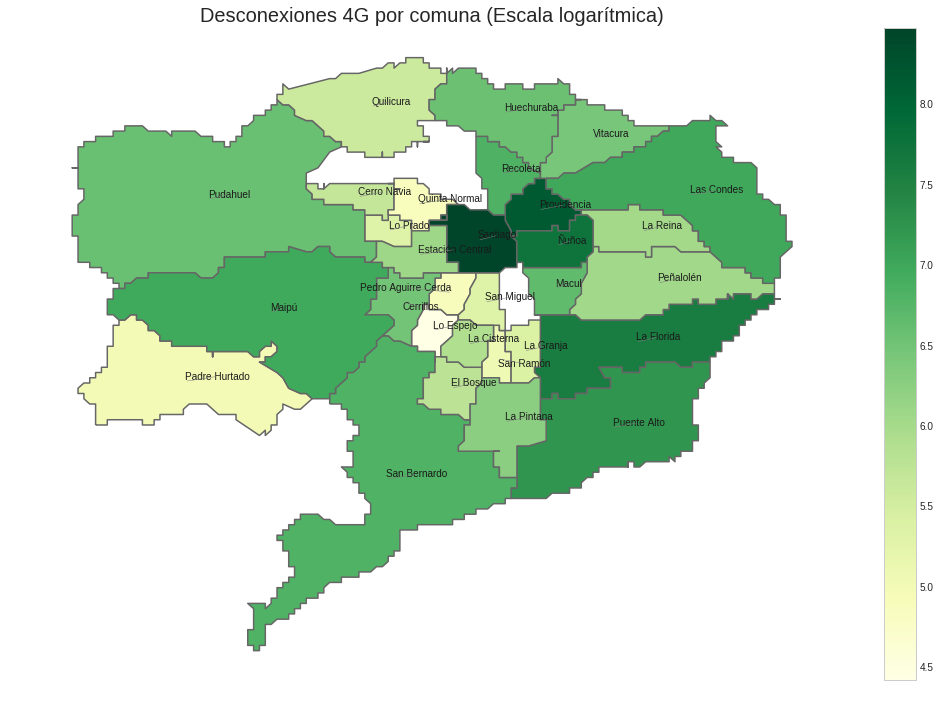

In [47]:
plotChoropleth(map_discon, 'log_total_discon', 'Desconexiones 4G por comuna (Escala logarítmica)', 'YlGn')

Se puede ver que la distribución de desconexiones se comporta similar al cómo se distribuían los eventos 4G en el Gran Santiago. El problema de este mapa es que no determina la proporcionalidad entre la totalidad de eventos 4G que registra cada comuna y sus desconexiones, por lo que Santiago siempre será la comuna con más desconexiones, pues es la que contabiliza la mayor cantidad de eventos 4G.

Con esto en mente, se presenta un mapa de Santiago que contiene la proporción entre desconexiones por comuna y la cantidad total de eventos 4G que ésta registra:

In [48]:
#Contamos la cantidad total de eventos 4G por comuna
totalcomuna4g = stgo_4g[stgo_4g['network_type'] == 14].groupby('comuna')['event_id'].count().reset_index()
#Renombramos las columnas de la tabla para hacer el INNER JOIN con el mapa anterior
totalcomuna4g.columns = ['NOM_COM', 'total_4g']
#Creamos una nueva tabla que contenga al mapa y el total de eventos 4G por comuna
map_discon4g = map_discon.merge(totalcomuna4g, on = 'NOM_COM', how  = 'inner')
#Agregamos una columna para calcular la proporcion
map_discon4g['prop4g'] = map_discon4g['total_discon']/map_discon4g['total_4g']

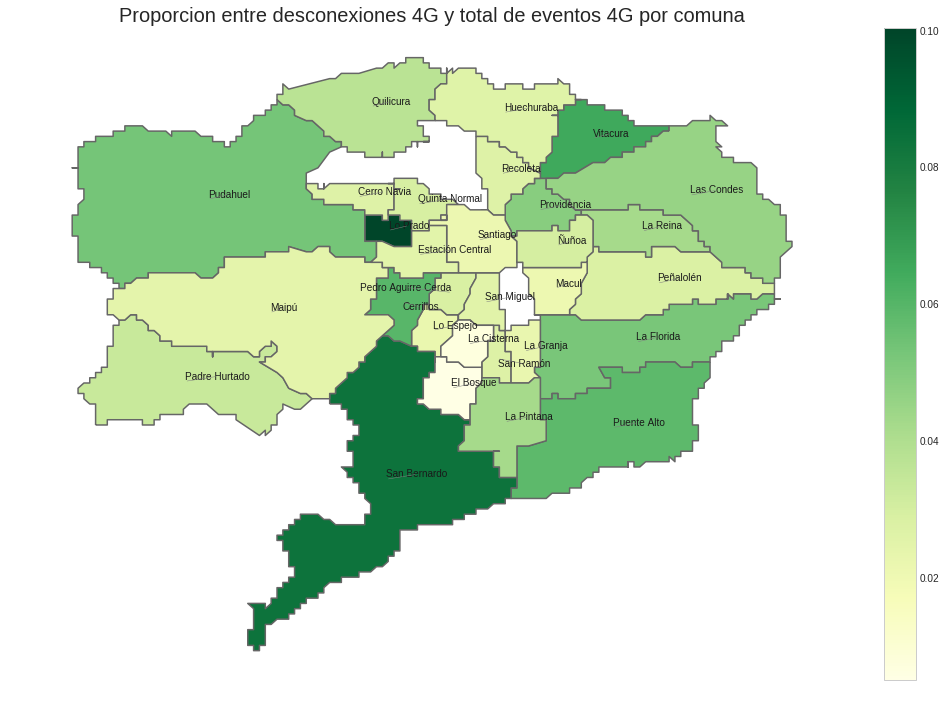

In [49]:
plotChoropleth(map_discon4g, 'prop4g', 'Proporcion entre desconexiones 4G y total de eventos 4G por comuna', 'YlGn')

Del mapa, se ve que las comunas con mayor cantidad de desconexiones 4G con respecto a la cantidad de eventos que registran son San Bernardo y Lo Prado, pero no se ve una tendencia en los datos hacia ciertas comunas. Un dato llamativo es que Santiago a pesar de registrar la mayor cantidad de eventos, no presenta una proporción alta de desconexiones. Además, notar que el valor máximo de desconexiones por cantidad de evento 4G es del 10%.

### ¿Cuándo ocurren las desconexiones?

Ya analizadas las tendencias geográficas de las desconexiones, podría existir alguna tendencia temporal. El siguiente gráfico muestra las desconexiones registradas distribuídas entre los días de medición, contrastadas con los eventos 4G:

In [50]:
#Agrupamos y contamos la cantidad total de desconexiones registradas por día
disconperday = disconnect_final.groupby([pd.Grouper(key = 'date_out', freq = 'D')]).size().reset_index()
disconperday.columns = ['date', 'total_discon']
disconperday['4g_events'] = day4g['4g_events']

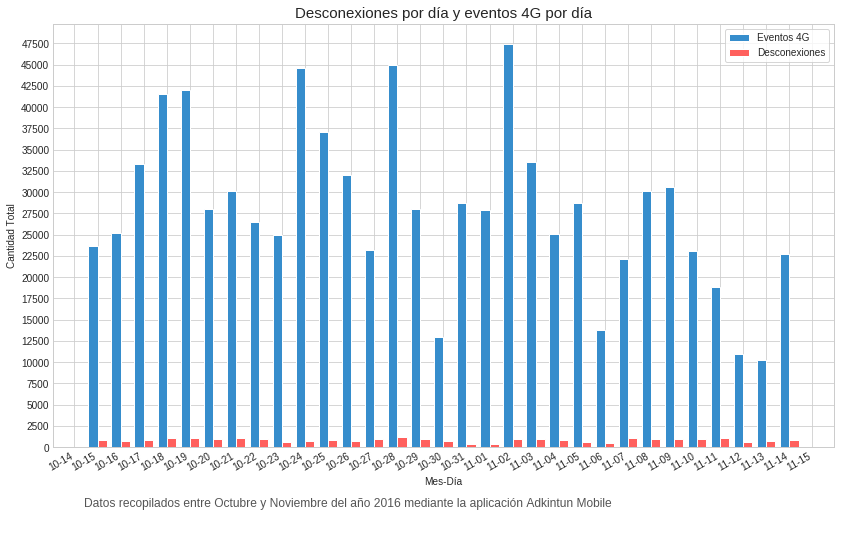

In [51]:
fig10, ax10 = plt.subplots(figsize=(14,8.65))
ax10.set(xlabel='Mes-Día', ylabel='Cantidad Total')
ax10.set_title('Desconexiones por día y eventos 4G por día', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax10.bar(mdates.date2num(disconperday['date'].values)-0.2, disconperday['4g_events'], color = '#368DCC', edgecolor = 'white',\
         label = 'Eventos 4G', width=0.4)
ax10.bar(mdates.date2num(disconperday['date'].values)+0.2, disconperday['total_discon'], color = '#FF605D', edgecolor = 'white',\
         label = 'Desconexiones', width=0.4)
ax10.xaxis.set_major_locator(mdates.DayLocator())
ax10.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax10.yaxis.set_major_locator(plt.MaxNLocator(20))
ax10.legend(frameon = True)
ax10.annotate('Datos recopilados entre Octubre y Noviembre del año 2016 mediante la aplicación Adkintun Mobile', xy=(0.1, .08),  xycoords= 'figure fraction', \
             horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
fig10.autofmt_xdate()

Se puede ver que las desconexiones se reparten de manera homogénea a lo largo de los días, no presentando alguna tendencia notoria. Lo llamativo es que la cantidad de desconexiones no necesariamente es proporcional a la cantidad de eventos 4G que se registran por día. Para verificar esto se genera un gráfico que compara las distribuciones normalizadas de los Eventos 4G y las desconexiones.

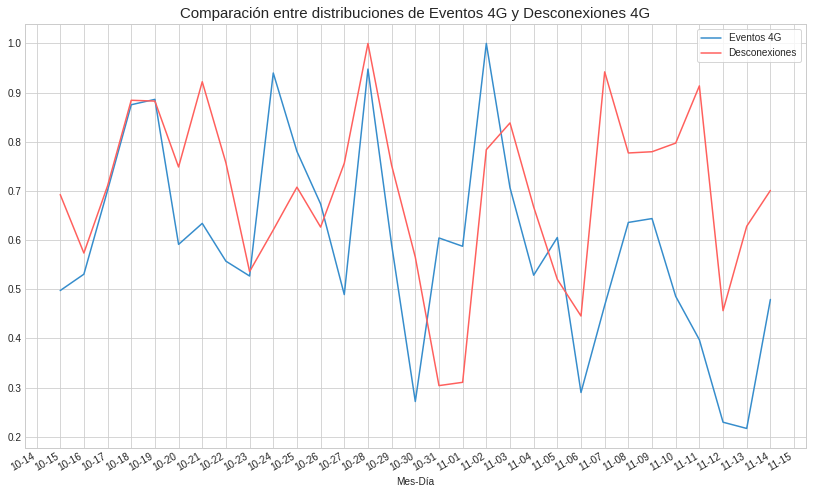

In [52]:
fig11, ax11 = plt.subplots(figsize = (14, 8.65))
ax11.plot(mdates.date2num(disconperday['date'].values), disconperday['4g_events']/disconperday['4g_events'].max(),\
         label = "Eventos 4G", color = '#368DCC')
ax11.plot(mdates.date2num(disconperday['date'].values), disconperday['total_discon']/disconperday['total_discon'].max(),\
         label = "Desconexiones", color = '#FF605D')
ax11.xaxis.set_major_locator(mdates.DayLocator())
ax11.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax11.set(xlabel = 'Mes-Día', ylabel = '')
ax11.set_title("Comparación entre distribuciones de Eventos 4G y Desconexiones 4G",\
               fontdict={'fontsize': '15', 'fontweight' : '3'})
ax11.legend(frameon = True)
fig11.autofmt_xdate()

### ¿Cuantas SIM registran desconexiones?

Considerando que la búsqueda de desconexiones se hizo sobre 147 identificadores SIM, es útil ver cual es la proporción de éstos que percibio desconexiones. El siguiente gráfico muestra la cantidad de SIMs que registran desconexiones y aquellas que no.

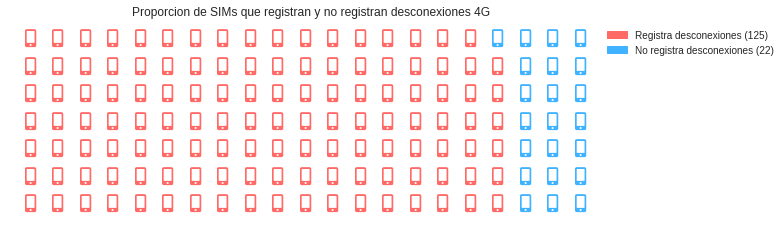

In [53]:
#Calculamos el número total de SIMs del dataset
ntotalsims = stgo_4g['sim_serial_number'].unique().size
#Calculamos el número de SIMs que registra desconexiones
ntotaldisconsims = disconnect_final['sim_serial_number'].unique().size
#Ploteo del tipo "waffle chart"
fig12 = plt.figure(figsize = (11, 20),
    FigureClass=Waffle, 
    rows=7,
    values=(ntotaldisconsims, ntotalsims-ntotaldisconsims),
    colors = ('#FF6A67', '#3FB3FF'),    
    title={'label': 'Proporcion de SIMs que registran y no registran desconexiones 4G', 'loc': 'center',},
    labels=["Registra desconexiones"+' ({})'.format(ntotaldisconsims), "No registra desconexiones"+' ({})'.format(ntotalsims-ntotaldisconsims)],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.0, 1), },
    icons = 'mobile-alt', icon_size = '18'
)

Es decir, aproximadamente el 85% de los identificadores SIMs en la muestra presentaron al menos una desconexión 4G entre Octubre y Noviembre del 2016.

### Relación entre carriers nominales y desconexiones

Cada identificador SIM está asociado nominalmente a un carrier determinado. La siguiente tabla presenta las estadísticas de las desconexiones registradas para cada carrier nominal, donde se muestra la cantidad de identificadores SIMs registrados por carrier y estadísticas asociadas a la cantidad de desconexiones medidas para cada SIM.

In [54]:
#Agrupamos las desconexiones medidas por SIM y contamos la cantidad de eventos asociados
simsdiscon = disconnect_final.groupby('sim_serial_number')['event_id'].count().reset_index().\
                rename(columns = {'event_id' : 'total_discon'})
#Cargamos la tabla que liga SIMs y carriers nominales
simsandcarriers = pd.read_csv('simsandcarriers.csv')
simsandcarriers.rename(columns = {'serial_number' : 'sim_serial_number', 'name' : 'carrier_name'}, inplace = True)
#Hacemos un INNER JOIN entre las SIMs con sus desconexiones y la tabla que liga SIMs y nombre de carriers.
sims_disc_carr = simsdiscon.merge(simsandcarriers[['sim_serial_number','carrier_name']], on = 'sim_serial_number',\
                                        how = 'left')
simtable = sims_disc_carr.groupby('carrier_name')['total_discon'].agg(['count', 'min', 'max', 'mean', 'median', 'std']).\
            round(2).reset_index().sort_values(by = 'count')
simtable.columns = ['Carrier', 'Cantidad de SIMs', 'Min', 'Max', 'Promedio', 'Mediana', 'Desv. Est.']
print(simtable)

         Carrier  Cantidad de SIMs  Min   Max  Promedio  Mediana  Desv. Est.
0      VTR Móvil                 2  118  2056   1087.00   1087.0     1370.37
1  Virgin Mobile                 8    5  1297    285.75     95.5      431.81
3          claro                18    3   808    233.56     67.5      294.77
5       movistar                23    1  1127    263.65    129.0      344.42
4          entel                36    1   664    111.25     42.5      154.31
2            WOM                38    1  1108    185.79     40.5      285.01


Para complementar esta información se adjunta un gráfico donde puede verse cómo se distribuye la cantidad de desconexiones asociadas a cada SIM con respecto a su carrier:

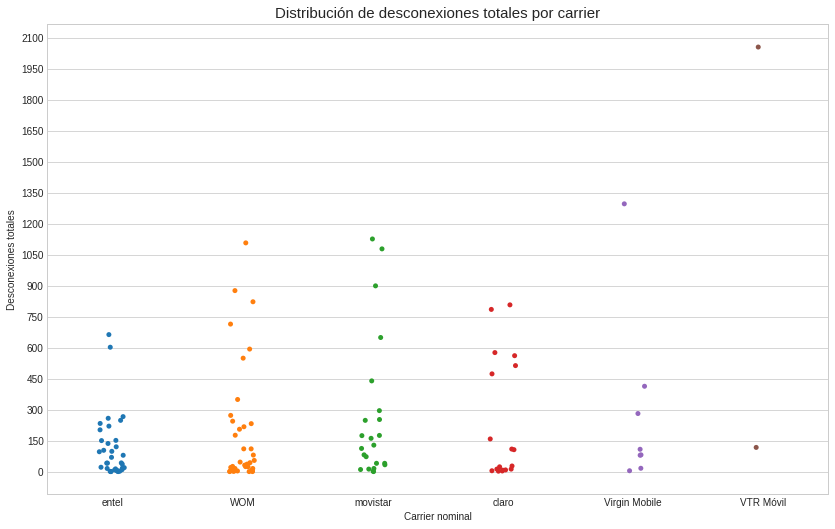

In [55]:
fig13, ax13 = plt.subplots(figsize=(14,8.65))
sns.stripplot(sims_disc_carr['carrier_name'], sims_disc_carr['total_discon'], ax = ax13)
ax13.set(xlabel = 'Carrier nominal', ylabel = 'Desconexiones totales')
ax13.set_title('Distribución de desconexiones totales por carrier', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax13.yaxis.set_major_locator(plt.MaxNLocator(20))

Dado que Virgin Mobile y VTR Móvil presentan datos muy fuera del rango normal de la muestra, se adjunta un gráfico con sólo las 4 compañías que presentan antenas en Santiago:

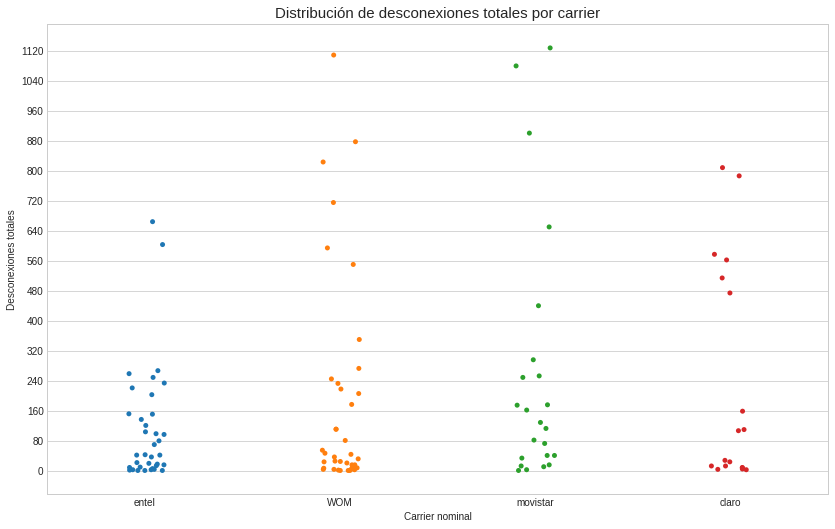

In [56]:
sinoutliers = sims_disc_carr.loc[(sims_disc_carr['carrier_name'] != 'Virgin Mobile') & \
                                 (sims_disc_carr['carrier_name'] != 'VTR Móvil')]
fig14, ax14 = plt.subplots(figsize=(14,8.65))
sns.stripplot(sinoutliers['carrier_name'], sinoutliers['total_discon'], ax = ax14)
ax14.set(xlabel = 'Carrier nominal', ylabel = 'Desconexiones totales')
ax14.set_title('Distribución de desconexiones totales por carrier', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax14.yaxis.set_major_locator(plt.MaxNLocator(20))

### Conclusión respecto a desconexiones:

A partir de lo antes mostrado, vemos que **no existe una tendencia dentro de los datos medidos que permita concluir la existencia de un sesgo en el servicio 4G entregado por los distintos carriers dentro del Gran Santiago.**

## Análisis temporal de conexiones  4G

En esta sección se analizará la duración de las conexiones 4G. Para encontrar estos largos nuevamente se trabajará sobre los eventos asociados a los 147 identificadores SIM dentro del dataset "Santiago 4G" para así darles coherencia temporal a los registros. Con esto en mente, se define lo siguiente:


* Sea $E_0 = \{e_0, e_1, ..., e_m\}$ la secuencia de eventos ordenados por fecha asociados al identificador SIM 0. Entenderemos por conexión 4G a una subsecuencia $S_0$ de $E_0$ de la forma $S_0 = \{e_j, e_{j+1}, ..., e_{j+k}\}$ donde cada elemento de $S_0$ es del tipo 4G. La duración total de la secuencia de eventos 4G será la diferencia temporal entre $e_j$ y $e_{j+k}$.


Además, para cada secuencia de eventos 4G encontrados se guardarán los siguientes atributos:

* **event_id_first** : El ID del primer evento registrado en la secuencia.
* **event_id_last** : El ID del último evento registrado en la secuencia.
* **date_first** : Fecha y hora del primer evento registrado en la secuencia.
* **date_last** : Fecha y hora del último evento registrado en la secuencia.
* **sim_serial_number** : Identificador SIM asociado a la secuencia de eventos.
* **nevents** : Cantidad de eventos registrados en la secuencia.


Debido a que dentro de la secuencia de eventos registrados para una SIM podrían existir eventos aislados o saltos temporales entre eventos 4G que no tengan coherencia (por ejemplo dos eventos 4G consecutivos con diferencias de 4 horas entre ellos), **se filtraron aquellos eventos que duraran más de 12 horas y aquellos eventos que duraran 0 segundos.**

In [57]:
#Proyectamos las columnas que nos interesan para el análisis de tiempo, usamos los datos sin filtrar por comuna
stgo_4g_proj= stgo_events_4g[['event_id', 'network_type', 'date', 'sim_serial_number', 'carrier_name', 'comuna']].copy()
#Agrupamos por sim los eventos
sim_group = stgo_4g_proj.groupby('sim_serial_number')

In [58]:
#Computamos las desconexiones, es solo fuerza bruta
sequences = []
seq_cols = ['event_id_first', 'event_id_last',
           'date_first', 'date_last',
           'sim_serial_number','nevents']
#Entramos a iterar sobre cada grupo de eventos asociado a cada SIM
for sim, group in sim_group:
    first = -1
    nevents = 0
    tope = len(group.index)
    #Iteramos sobre la tabla con el índice i
    for i in range(tope):
        #Chequeamos si estamos al final de la tabla
        if i == tope-1:
            #Chequeamos si no existe un evento registrado como primero
            if first == -1:
                continue
            #En caso contrario, si el evento es 4G, lo registro como último
            elif group.iat[i,1] == 14:
                nevents+=1
                seq = (group.iat[first,0], group.iat[i,0],
                          group.iat[first,2], group.iat[i,2],
                               group.iat[i,3], nevents)
                sequences.append(seq)
            #Si no es 4G y first tenía un registro, entonces el evento anterior era 4G necesariamente.
            else:
                seq = (group.iat[first,0], group.iat[i-1,0],
                          group.iat[first,2], group.iat[i-1,2],
                               group.iat[i-1,3], nevents)
                sequences.append(seq)
        #Si no estamos al final de la tabla
        else:
            #Verificamos si el evento que estamos mirando es 4G
            if group.iat[i,1] == 14:
                #Si es 4G y first está libre, este es el primer evento 4G que estamos mirando
                if first == -1:
                    nevents+=1
                    first = i
                    continue
                #Si es 4G, y hay un first registrado, solo aumentamos la cantidad total de eventos
                else:
                    nevents+=1
                    continue
            #Si no es 4G, entonces podemos estar en una cadena de eventos No4G o al final de una cadena 4G
            else:
                #Si first no está registrado, entonces seguimos iterando
                if first == -1:
                    continue
                #Si hay un first registrado y no somos 4G, el anterior evento lo era por lo que guardamos la secuencia
                else:
                    seq = (group.iat[first,0], group.iat[i-1,0],
                          group.iat[first,2], group.iat[i-1,2],
                               group.iat[i-1,3], nevents)
                    sequences.append(seq)
                    #Reiniciamos las variables globales
                    first = -1
                    nevents = 0
                

In [59]:
#Generamos el dataframe con las secuencias de eventos
seq_events = pd.DataFrame(sequences)
seq_events.columns = seq_cols
#Generamos la columna 'delta' que muestra las diferencias de tiempo entre los primer y último eventos registrados
seq_events['delta'] = seq_events['date_last']-seq_events['date_first']
#Filtramos aquellos eventos que duren más de 12 horas
seq_events = seq_events[seq_events['delta'] < pd.Timedelta('12 hours')]
#Filtramos aquellos eventos que duren menos de 0 segundos
seq_events = seq_events[seq_events['delta'] > pd.Timedelta('0 seconds')]

Con todo esto dicho, se adjunta un histograma con la distribución de la duración de las 32730 secuencias de eventos medidas en minutos:

In [60]:
#Extraemos los delta de tiempo para ver cómo se distribuyen
seq_deltas = seq_events['delta'].astype('timedelta64[m]').sort_values()

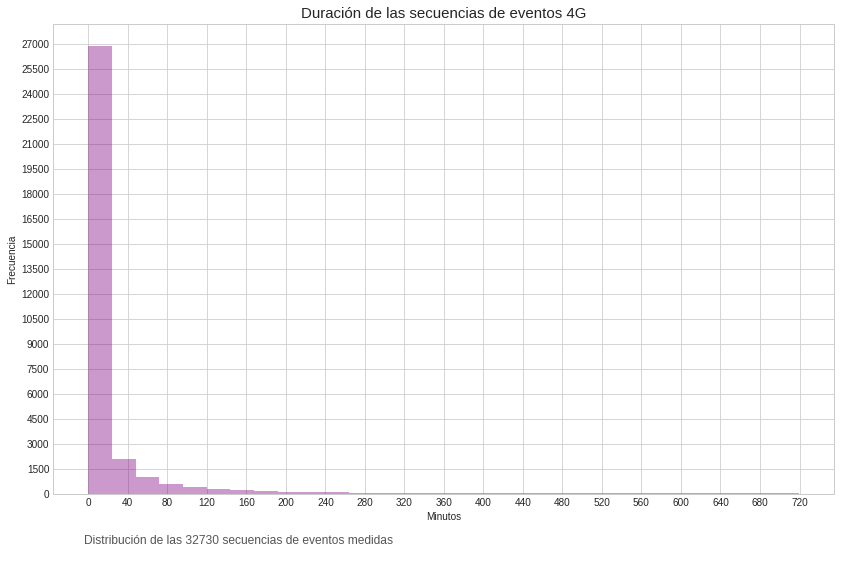

In [61]:
fig15, ax15 = plt.subplots(figsize=(14,8.65))
sns.distplot(seq_deltas, hist=True, kde=False, bins=30, color = 'purple', ax = ax15)
ax15.set_title('Duración de las secuencias de eventos 4G', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax15.set(xlabel='Minutos', ylabel='Frecuencia')
ax15.yaxis.set_major_locator(plt.MaxNLocator(20))
ax15.xaxis.set_major_locator(plt.MaxNLocator(20))
ax15.annotate('Distribución de las 32730 secuencias de eventos medidas', xy=(0.1, .048),  xycoords= 'figure fraction',\
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

Nuevamente se puede ver una distribución de cola, donde la mayor cantidad de secuencias se agrupa entre los 0 y 80 minutos. Para una visión más detallada, se adjunta el gráfico con el corte hasta el percentil 90 de la muestra:

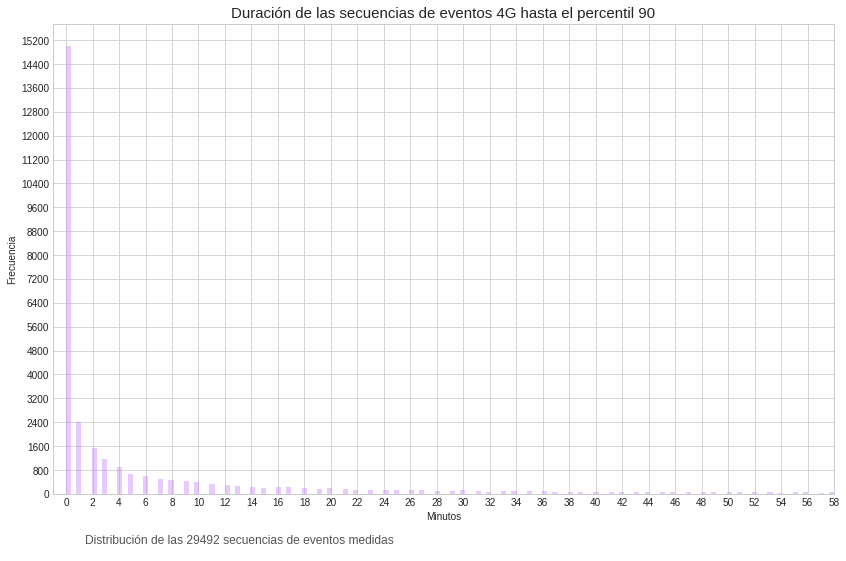

In [62]:
fig16, ax16 = plt.subplots(figsize=(14,8.65))
#En distplot, el primer argumento contiene los datos recortados hasta el percentil 90
sns.distplot(seq_deltas[seq_deltas <= seq_deltas.quantile(0.90)], hist=True, kde=False, bins='auto', color = '#C37DFF', \
             ax = ax16)
ax16.set_title('Duración de las secuencias de eventos 4G hasta el percentil 90', \
               fontdict={'fontsize': '15', 'fontweight' : '3'})
ax16.set(xlabel='Minutos', ylabel='Frecuencia')
ax16.yaxis.set_major_locator(plt.MaxNLocator(20))
ax16.xaxis.set_major_locator(plt.MaxNLocator(30))
ax16.set_xlim(-1, 58)
ax16.annotate('Distribución de las 29492 secuencias de eventos medidas', xy=(0.1, .048),  \
            xycoords= 'figure fraction',\
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

Se puede ver que la mayoría de las secuencias no superan los 2 minutos de duración y que el valor máximo alcanzado bordea los 58 minutos. Finalmente para describir por completo la duración de las secuencias, se adjunta el histograma de la distribución de los eventos alojados después del percentil 90:

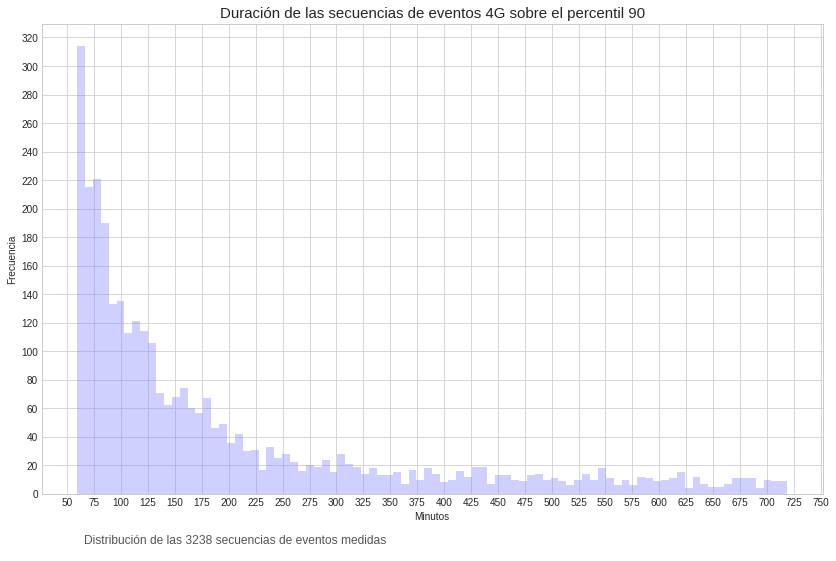

In [63]:
fig17, ax17 = plt.subplots(figsize=(14,8.65))
#En distplot, el primer argumento contiene los datos recortados hasta el percentil 90
sns.distplot(seq_deltas[seq_deltas > seq_deltas.quantile(0.90)], hist=True, kde=False, bins=90, color = '#898AFF', \
             ax = ax17)
ax17.set_title('Duración de las secuencias de eventos 4G sobre el percentil 90', \
               fontdict={'fontsize': '15', 'fontweight' : '3'})
ax17.set(xlabel='Minutos', ylabel='Frecuencia')
ax17.yaxis.set_major_locator(plt.MaxNLocator(20))
ax17.xaxis.set_major_locator(plt.MaxNLocator(30))
ax17.annotate('Distribución de las 3238 secuencias de eventos medidas', xy=(0.1, .048),  \
            xycoords= 'figure fraction',\
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

Si bien estas últimas mediciones son una pequeña cantidad de secuencias en comparación con la muestra total, la cantidad de registros que se alojan aquí no es menor. Los valores registrados aquí pueden deberse a cómo se miden los eventos 4G dentro del dataset.

### Cantidad de eventos por secuencia

Para verificar la correctitud de la medición de secuencias, se hará un análisis sobre la cantidad de eventos registrados sobre cada secuencia. En primer lugar se buscarán outliers dentro del dataset mediante el siguiente gráfico de banda:

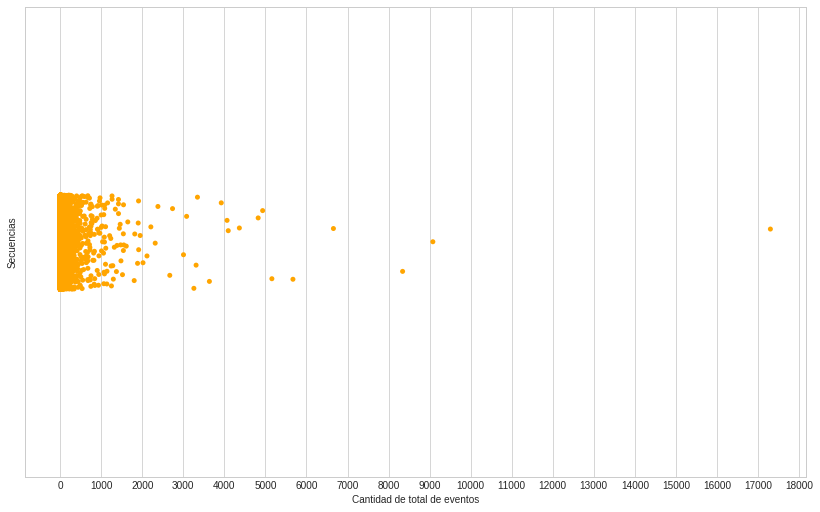

In [64]:
fig18, ax18 = plt.subplots(figsize=(14,8.65))
sns.stripplot(seq_events['nevents'], ax = ax18, color = 'orange')
ax18.set(xlabel = 'Cantidad de total de eventos', ylabel = 'Secuencias')
ax18.xaxis.set_major_locator(plt.MaxNLocator(20))

Se puede ver que la mayor parte de las secuencias registran menos de 1000 eventos en total. Así mismo, se registra un outlier que almacena más de 170000 eventos 4G. Para hacer una idea de por qué existe ese outlier, se muestran algunos timestamps de los eventos 4G medidos dentro de esa secuencia:

In [65]:
simoutlier = seq_events[seq_events['nevents'] == seq_events['nevents'].max()]['sim_serial_number'].values[0]
outlier = sim_group.get_group(simoutlier)
print(outlier[['network_type','date']].head(n=25))

      network_type                    date
1644            14 2016-10-15 00:30:10.042
1645            14 2016-10-15 00:30:10.042
1646            14 2016-10-15 00:30:10.042
1647            14 2016-10-15 00:30:10.042
1648            14 2016-10-15 00:30:10.042
1649            14 2016-10-15 00:30:10.042
1650            14 2016-10-15 00:30:10.042
1651            14 2016-10-15 00:30:10.042
1652            14 2016-10-15 00:30:10.042
1653            14 2016-10-15 00:30:10.042
1654            14 2016-10-15 00:30:10.042
1655            14 2016-10-15 00:30:10.042
1656            14 2016-10-15 00:30:10.042
1657            14 2016-10-15 00:30:10.042
1658            14 2016-10-15 00:30:10.042
1659            14 2016-10-15 00:30:10.042
1660            14 2016-10-15 00:30:10.042
1661            14 2016-10-15 00:30:10.042
1662            14 2016-10-15 00:30:10.042
1810            14 2016-10-15 00:35:13.787
1811            14 2016-10-15 00:35:13.787
1812            14 2016-10-15 00:35:13.787
1813       

Es decir, ese outlier se explica por la existencia de eventos 4G que no avanzan temporalmente. Ya con esto visto, veamos como distribuye la mayor parte de la muestra, nuevamente hasta el percentil 90:

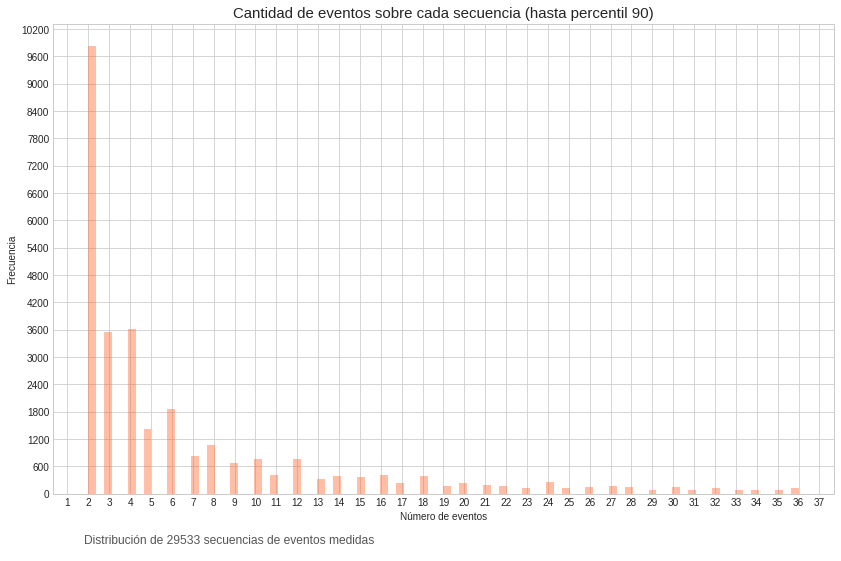

In [66]:
seq_nevents = seq_events['nevents']
fig19, ax19 = plt.subplots(figsize=(14,8.65))
#En distplot, el primer argumento contiene los datos recortados hasta el percentil 90
sns.distplot(seq_nevents[seq_nevents <= seq_nevents.quantile(0.90)], hist=True, kde=False, bins=90, color = '#FF5D1E', \
             ax = ax19)
ax19.set_title('Cantidad de eventos sobre cada secuencia (hasta percentil 90)', \
               fontdict={'fontsize': '15', 'fontweight' : '3'})
ax19.set(xlabel='Número de eventos', ylabel='Frecuencia')
ax19.yaxis.set_major_locator(plt.MaxNLocator(20))
ax19.xaxis.set_major_locator(plt.MaxNLocator(40))
ax19.annotate('Distribución de 29533 secuencias de eventos medidas', xy=(0.1, .048),  \
            xycoords= 'figure fraction',\
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

Del histograma puede verse que la mayor parte de las secuencias alojan solamente 2 eventos, lo cual explicaría los valores bajos de la distribuciones de tiempo hechas con anterioridad.

### Analisis de tiempos promedio sobre carriers

Finalmente, se adjuntan dos tablas que muestran los valores medidos con respecto a la duración de las secuencias 4G para los carriers nominales asociados a los identificadores SIMs de la muestra.

In [67]:
#Adjuntamos el nombre del carrier asociado a cada SIM
seqsimevents = seq_events.merge(simsandcarriers[['sim_serial_number','carrier_name']], on = 'sim_serial_number',\
                                        how = 'left')
#Transformamos los deltas de tiempo a int para calcular estadísticas sobre estos
seqsimevents['deltaint'] = seqsimevents['delta'].values.astype(np.int64)
aggs = ['count','min','max','mean', 'std']
#Aplicamos agregaciones sobre los delta
carrierdeltas = seqsimevents.groupby('carrier_name')['deltaint'].agg(['count','min','max','mean', 'std']).\
                sort_values(by = 'mean')
for agg in aggs[1:]:
    #Modificamos los valores int a valores timedelta
    carrierdeltas[agg] = pd.to_timedelta(carrierdeltas[agg], unit = 'ns')
#Modificamos los valores para que se vean mejor
carrierdeltas.columns = ['Cantidad de secuencias', 'Min', 'Max', 'Promedio', 'Desv Est']
carrierdeltas.index.names = ['Carrier']
carrierdeltas

,Cantidad de secuencias,Min,Max,Promedio,Desv Est
Carrier,,,,,
VTR Móvil,1477,00:00:00.008000,11:59:23.274000,00:11:42.001570,00:53:06.502148
Virgin Mobile,3534,00:00:00.002000,11:24:45.585000,00:16:33.915696,00:51:10.587057
WOM,14944,00:00:00.007000,11:59:43.814000,00:19:39.399065,01:08:15.163445
movistar,4544,00:00:00.001000,11:56:22.317000,00:31:24.462689,01:29:20.645102
claro,3497,00:00:00.009000,11:37:43.734000,00:33:52.110362,01:21:30.049166
entel,4734,00:00:00.011000,11:55:47.565000,00:42:49.789533,01:45:46.081497


De la tabla se puede ver que la mayor cantidad de las secuencias se las lleva WOM, lo cual coincide con lo visto en la distribución de eventos 4G. Ahora, esto tambien puede significar que existe gran intermitencia en el servicio de WOM, pero no es lo visto en el análisis de desconexiones. Además de la tabla se ve que el mejor servicio en promedio lo entrega Entel, al tener una duración promedio de 42 minutos en su servicio 4G.

### Conclusión respecto al análisis temporal:

Del análisis temporal puede verse que **las secuencias de eventos 4G tienen comportamientos intermitentes**, al presentarse en su mayor parte con duraciones menores al minuto. Por otra parte, la existencia de outliers que registran duraciones mayores a las 12 horas puede deberse al tipo de medición efectuada sobre cada evento 4G.